In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torchmetrics
import torch.nn as nn

In [2]:
class ConvAttMLP_origon(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.fc11=nn.Linear(1100,1100)
        self.bn1= nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(2200, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
        
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        #self.pool1 = nn.MaxPool1d(3,stride=3)
        self.bn4=nn.BatchNorm1d(3300)
        self.conv2 = nn.Conv1d(8, 16, 5,padding=2)
        self.bn5=nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3,stride=3)
        self.conv3=nn.Conv1d(16,1,1,stride=1)
        self.pool3=nn.MaxPool1d(3,stride=3)
        self.bn6=nn.BatchNorm1d(1100)
        #self.fc1 = nn.Linear(16*5*5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        self.bn7=nn.BatchNorm1d(2200)
        
        #self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.avg_pool=nn.AvgPool1d(kernel_size=3300)
        #self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.max_pool=nn.MaxPool1d(kernel_size=3300)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        x=self.bn0(x)
        #print('x:',x.shape)
        x1= F.relu(self.drop(self.bn1(self.fc1(x))))
        x1=F.relu(self.drop(self.bn1(self.fc11(x1))))
        
        x0=torch.unsqueeze(x,1)
        #print("x0:",x0.shape)
        
        
        x2=F.relu(self.conv1(x0))
        #x2=x2+x0
        #print('x2:',x2.shape)
        x2=F.relu(self.conv2(x2))
        #x2=x2+x0
        #print('x2:',x2.shape)
        
        #print('x2_argpool:',x2.shape)
        avg_pool=self.avg_pool(x2)
        #print('avg_pool:',avg_pool.shape)
        avg_out = self.fc(self.avg_pool(x2))
        max_pool=self.max_pool(x2)
        #print('max_pool:',max_pool.shape)
        max_out = self.fc(self.max_pool(x2))
        out = avg_out + max_out
        x2=torch.mul(x2,out)
        x2=F.relu(self.conv3(x2))
        #print('x2:',x2.shape)
        #x2=x0+x2
        
        #print('x2:',x2.shape)
        #x2=x0+x2####skip connection
        #x2=torch.squeeze(x2,1)
        #x2=self.bn5(x2)
        #x2 = torch.unsqueeze(x2, 1)  # 在第 1 维（通道维）添加维度#####################################
        #x2 = self.pool3(x2)  # 现在可以通过 MaxPool1d 了
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        #x3=torch.add(x1,x2)
        x3=torch.cat([x1,x2],dim=1)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x4))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 
#modela=ConvAttMLP_origon()
#modela.cuda()
#print(modela)    
 

In [10]:
class ConvAtt_without_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.fc11=nn.Linear(1100,1100)
        
        self.bn1= nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(1100, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
        
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        #self.pool1 = nn.MaxPool1d(3,stride=3)
        self.bn4=nn.BatchNorm1d(3300)
        self.conv2 = nn.Conv1d(8, 16, 5,padding=2)
        self.bn5=nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3,stride=3)
        self.conv3=nn.Conv1d(16,1,1,stride=1)
        self.pool3=nn.MaxPool1d(3,stride=3)
        self.bn6=nn.BatchNorm1d(1100)
        #self.fc1 = nn.Linear(16*5*5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        self.bn7=nn.BatchNorm1d(1100)
        
        #self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.avg_pool=nn.AvgPool1d(kernel_size=3300)
        #self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.max_pool=nn.MaxPool1d(kernel_size=3300)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        x=self.bn0(x)
        #print('x:',x.shape)
        #x1= F.relu(self.drop(self.bn1(self.fc11(self.fc1(x)))))
        
        
        x0=torch.unsqueeze(x,1)
        #print("x0:",x0.shape)
        
        
        x2=F.relu(self.conv1(x0))
        #x2=x2+x0
        #print('x2:',x2.shape)
        x2=F.relu(self.conv2(x2))
        #x2=x2+x0
        #print('x2:',x2.shape)
        
        #print('x2_argpool:',x2.shape)
        avg_pool=self.avg_pool(x2)
        #print('avg_pool:',avg_pool.shape)
        avg_out = self.fc(self.avg_pool(x2))
        max_pool=self.max_pool(x2)
        #print('max_pool:',max_pool.shape)
        max_out = self.fc(self.max_pool(x2))
        out = avg_out + max_out
        x2=torch.mul(x2,out)
        x2=F.relu(self.conv3(x2))
        #print('x2:',x2.shape)
        x2=x0+x2
        
        #print('x2:',x2.shape)
        #x2=x0+x2####skip connection
        #x2=torch.squeeze(x2,1)
        #x2=self.bn5(x2)
        #x2 = torch.unsqueeze(x2, 1)  # 在第 1 维（通道维）添加维度#####################################
        #x2 = self.pool3(x2)  # 现在可以通过 MaxPool1d 了
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        #x3=torch.add(x1,x2)
        x4=self.bn7(x2)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x4))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 
    
#modela=ConvAtt_without_MLP()
#modela.cuda()
#print(modela)   

In [7]:
class ConvAttMLP_res_concat(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.bn1= nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(2200, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
        
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        #self.pool1 = nn.MaxPool1d(3,stride=3)
        self.bn4=nn.BatchNorm1d(3300)
        self.conv2 = nn.Conv1d(8, 16, 5,padding=2)
        self.bn5=nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3,stride=3)
        self.conv3=nn.Conv1d(16,1,1,stride=1)
        self.pool3=nn.MaxPool1d(3,stride=3)
        self.bn6=nn.BatchNorm1d(1100)
        #self.fc1 = nn.Linear(16*5*5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        self.bn7=nn.BatchNorm1d(2200)
        
        #self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.avg_pool=nn.AvgPool1d(kernel_size=3300)
        #self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.max_pool=nn.MaxPool1d(kernel_size=3300)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        x=self.bn0(x)
        #print('x:',x.shape)
        x1= F.relu(self.drop(self.bn1(self.fc1(x))))
        
        
        x0=torch.unsqueeze(x,1)
        #print("x0:",x0.shape)
        
        
        x2=F.relu(self.conv1(x0))
        #x2=x2+x0
        #print('x2:',x2.shape)
        x2=F.relu(self.conv2(x2))
        #x2=x2+x0
        #print('x2:',x2.shape)
        
        #print('x2_argpool:',x2.shape)
        avg_pool=self.avg_pool(x2)
        #print('avg_pool:',avg_pool.shape)
        avg_out = self.fc(self.avg_pool(x2))
        max_pool=self.max_pool(x2)
        #print('max_pool:',max_pool.shape)
        max_out = self.fc(self.max_pool(x2))
        out = avg_out + max_out
        x2=torch.mul(x2,out)
        x2=F.relu(self.conv3(x2))
        #print('x2:',x2.shape)
        #x2=x0+x2
        
        #print('x2:',x2.shape)
        x2=x0+x2####skip connection
        #x2=torch.squeeze(x2,1)
        #x2=self.bn5(x2)
        #x2 = torch.unsqueeze(x2, 1)  # 在第 1 维（通道维）添加维度#####################################
        #x2 = self.pool3(x2)  # 现在可以通过 MaxPool1d 了
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        #x3=torch.add(x1,x2)
        x3=torch.cat([x1,x2],dim=1)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x3))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 
#modela=ConvAttMLP_res_concat()
#modela.cuda()
#print(modela)

In [3]:
import time

import torch
import torch.nn as nn
from torch.nn import functional as F

class ConvAttMLP_origon_add(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.bn1= nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(1100, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
        
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        #self.pool1 = nn.MaxPool1d(3,stride=3)
        self.bn4=nn.BatchNorm1d(3300)
        self.conv2 = nn.Conv1d(8, 16, 5,padding=2)
        self.bn5=nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3,stride=3)
        self.conv3=nn.Conv1d(16,1,1,stride=1)
        self.pool3=nn.MaxPool1d(3,stride=3)
        self.bn6=nn.BatchNorm1d(1100)
        #self.fc1 = nn.Linear(16*5*5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        self.bn7=nn.BatchNorm1d(1100)
        
        #self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.avg_pool=nn.AvgPool1d(kernel_size=3300)
        #self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.max_pool=nn.MaxPool1d(kernel_size=3300)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        x=self.bn0(x)
        #print('x:',x.shape)
        x1= F.relu(self.drop(self.bn1(self.fc1(x))))
        
        
        x0=torch.unsqueeze(x,1)
        #print("x0:",x0.shape)
        
        
        x2=F.relu(self.conv1(x0))
        #x2=x2+x0
        #print('x2:',x2.shape)
        x2=F.relu(self.conv2(x2))
        #x2=x2+x0
        #print('x2:',x2.shape)
        
        #print('x2_argpool:',x2.shape)
        avg_pool=self.avg_pool(x2)
        #print('avg_pool:',avg_pool.shape)
        avg_out = self.fc(self.avg_pool(x2))
        max_pool=self.max_pool(x2)
        #print('max_pool:',max_pool.shape)
        max_out = self.fc(self.max_pool(x2))
        out = avg_out + max_out
        x2=torch.mul(x2,out)
        x2=F.relu(self.conv3(x2))
        #print('x2:',x2.shape)
        #x2=x0+x2
        
        #print('x2:',x2.shape)
        #x2=x0+x2####skip connection
        x2=torch.squeeze(x2,1)
        x2=self.bn5(x2)
        x2 = torch.unsqueeze(x2, 1)  # 在第 1 维（通道维）添加维度#####################################
        #x2 = self.pool3(x2)  # 现在可以通过 MaxPool1d 了
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        x3=torch.add(x1,x2)
        #x3=torch.cat([x1,x2],dim=1)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x3))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 
#modela=ConvAttMLP_origon_add()
#modela.cuda()
#print(modela)

In [2]:
class ConvAttMLP_10layers_add_withou_res(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.fc11=nn.Linear(1100,1100)
        self.bn1 = nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(1100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 9)
        self.bn3 = nn.BatchNorm1d(9)

        self.drop = nn.Dropout(0.5)
        
        
        # Conv layers
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.conv3 = nn.Conv1d(16, 16, 5, padding=2)  # Change to match input channel 16
        self.conv4 = nn.Conv1d(16, 1, 1, stride=1)
        #self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.bn4 = nn.BatchNorm1d(3300)
        #self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.bn5 = nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3, stride=3)
        #self.conv3 = nn.Conv1d(16, 1, 1, stride=1)
        self.pool3 = nn.MaxPool1d(3, stride=3)
        self.bn6 = nn.BatchNorm1d(1100)
        
        self.bn7=nn.BatchNorm1d(1100)

        self.avg_pool = nn.AvgPool1d(kernel_size=3300)
        self.max_pool = nn.MaxPool1d(kernel_size=3300)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )

        # Define a list to hold multiple layers
        self.layers = nn.ModuleList([self._create_layer() for _ in range(2)])

    def _create_layer(self):
        """Create a single layer using conv and pooling operations as defined in the original forward method."""
        return nn.Sequential(
            nn.Conv1d(1, 8, 5, padding=2),
            nn.BatchNorm1d(3300),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.Conv1d(16, 16, 5, padding=2),  # Match input/output channel
            nn.Conv1d(16, 1, 1, stride=1),  # This will receive 16 channels and output 1
            nn.AvgPool1d(kernel_size=3300),
            nn.MaxPool1d(kernel_size=3300)
        )

    def forward(self, x):
        x = self.bn0(x)
        x1= F.relu(self.drop(self.bn1(self.fc11(self.fc1(x)))))
        
        
        x0 = torch.unsqueeze(x, 1)  # Add a channel dimension
        #print('x0:',x0.shape)
        # Pass through each layer sequentially
        for layer in self.layers:
            
            x2 = F.relu(layer[0](x0))  # Conv1
            x2 = F.relu(layer[2](x2))  # Conv2
            avg_pool = self.avg_pool(x2)
            avg_out = self.fc(self.avg_pool(x2))
            max_pool = self.max_pool(x2)
            max_out = self.fc(self.max_pool(x2))
            out = avg_out + max_out
            x2 = torch.mul(x2, out)
            x2 = F.relu(layer[4](x2))  # Conv3
            #x2 = x0 + x2  # Skip connection######################without_res
            x0 = x2  # Pass to next layer
            #print('x0+++:',x0.shape)
            
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        x3=torch.add(x1,x2)
        #x3=torch.cat([x1,x2],dim=1)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x4))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 
    
modela=ConvAttMLP_10layers_add_withou_res()
modela.cuda()
print(modela)    

ConvAttMLP_10layers_add_withou_res(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=1100, bias=True)
  (fc11): Linear(in_features=1100, out_features=1100, bias=True)
  (bn1): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1100, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(3300, eps=1e-05, momentum

In [6]:
class ConvAttMLP_10layers_add__(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.fc11=nn.Linear(1100,1100)
        self.bn1 = nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(1100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 9)
        self.bn3 = nn.BatchNorm1d(9)

        self.drop = nn.Dropout(0.5)
        
        
        # Conv layers
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.conv3 = nn.Conv1d(16, 16, 5, padding=2)  # Change to match input channel 16
        self.conv4 = nn.Conv1d(16, 1, 1, stride=1)
        #self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.bn4 = nn.BatchNorm1d(3300)
        #self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.bn5 = nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3, stride=3)
        #self.conv3 = nn.Conv1d(16, 1, 1, stride=1)
        self.pool3 = nn.MaxPool1d(3, stride=3)
        self.bn6 = nn.BatchNorm1d(1100)
        
        self.bn7=nn.BatchNorm1d(1100)

        self.avg_pool = nn.AvgPool1d(kernel_size=3300)
        self.max_pool = nn.MaxPool1d(kernel_size=3300)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )

        # Define a list to hold multiple layers
        self.layers = nn.ModuleList([self._create_layer() for _ in range(2)])

    def _create_layer(self):
        """Create a single layer using conv and pooling operations as defined in the original forward method."""
        return nn.Sequential(
            nn.Conv1d(1, 8, 5, padding=2),
            nn.BatchNorm1d(3300),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.Conv1d(16, 16, 5, padding=2),  # Match input/output channel
            nn.Conv1d(16, 1, 1, stride=1),  # This will receive 16 channels and output 1
            nn.AvgPool1d(kernel_size=3300),
            nn.MaxPool1d(kernel_size=3300)
        )

    def forward(self, x):
        x = self.bn0(x)
        x1= F.relu(self.drop(self.bn1(self.fc11(self.fc1(x)))))
        
        
        x0 = torch.unsqueeze(x, 1)  # Add a channel dimension
        #print('x0:',x0.shape)
        # Pass through each layer sequentially
        for layer in self.layers:
            
            x2 = F.relu(layer[0](x0))  # Conv1
            x2 = F.relu(layer[2](x2))  # Conv2
            avg_pool = self.avg_pool(x2)
            avg_out = self.fc(self.avg_pool(x2))
            max_pool = self.max_pool(x2)
            max_out = self.fc(self.max_pool(x2))
            out = avg_out + max_out
            x2 = torch.mul(x2, out)
            x2 = F.relu(layer[4](x2))  # Conv3
            x2 = x0 + x2  # Skip connection
            x0 = x2  # Pass to next layer
            #print('x0+++:',x0.shape)
            
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        x3=torch.add(x1,x2)
        #x3=torch.cat([x1,x2],dim=1)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x4))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 
    
#modela=ConvAttMLP_10layers_add__()
#modela.cuda()
#print(modela)    

In [8]:
class ConvAttMLP_10layers_add(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.fc11=nn.Linear(1100,1100)
        self.bn1 = nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(2200, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 9)
        self.bn3 = nn.BatchNorm1d(9)

        self.drop = nn.Dropout(0.5)
        
        
        # Conv layers
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.conv3 = nn.Conv1d(16, 16, 5, padding=2)  # Change to match input channel 16
        self.conv4 = nn.Conv1d(16, 1, 1, stride=1)
        #self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.bn4 = nn.BatchNorm1d(3300)
        #self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.bn5 = nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3, stride=3)
        #self.conv3 = nn.Conv1d(16, 1, 1, stride=1)
        self.pool3 = nn.MaxPool1d(3, stride=3)
        self.bn6 = nn.BatchNorm1d(1100)
        
        self.bn7=nn.BatchNorm1d(2200)

        self.avg_pool = nn.AvgPool1d(kernel_size=3300)
        self.max_pool = nn.MaxPool1d(kernel_size=3300)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )

        # Define a list to hold multiple layers
        self.layers = nn.ModuleList([self._create_layer() for _ in range(2)])

    def _create_layer(self):
        """Create a single layer using conv and pooling operations as defined in the original forward method."""
        return nn.Sequential(
            nn.Conv1d(1, 8, 5, padding=2),
            nn.BatchNorm1d(3300),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.Conv1d(16, 16, 5, padding=2),  # Match input/output channel
            nn.Conv1d(16, 1, 1, stride=1),  # This will receive 16 channels and output 1
            nn.AvgPool1d(kernel_size=3300),
            nn.MaxPool1d(kernel_size=3300)
        )

    def forward(self, x):
        x = self.bn0(x)
        x1= F.relu(self.drop(self.bn1(self.fc11(self.fc1(x)))))
        
        
        x0 = torch.unsqueeze(x, 1)  # Add a channel dimension
        #print('x0:',x0.shape)
        # Pass through each layer sequentially
        for layer in self.layers:
            
            x2 = F.relu(layer[0](x0))  # Conv1
            x2 = F.relu(layer[2](x2))  # Conv2
            avg_pool = self.avg_pool(x2)
            avg_out = self.fc(self.avg_pool(x2))
            max_pool = self.max_pool(x2)
            max_out = self.fc(self.max_pool(x2))
            out = avg_out + max_out
            x2 = torch.mul(x2, out)
            x2 = F.relu(layer[4](x2))  # Conv3
            x2 = x0 + x2  # Skip connection
            x0 = x2  # Pass to next layer
            #print('x0+++:',x0.shape)
            
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        #x3=torch.add(x1,x2)
        x3=torch.cat([x1,x2],dim=1)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x4))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 
    
#modela=ConvAttMLP_10layers_add()
#modela.cuda()
#print(modela)    

In [4]:
import time

import torch
import torch.nn as nn
from torch.nn import functional as F

class ConvAttMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.bn1= nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(1100, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
        
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        #self.pool1 = nn.MaxPool1d(3,stride=3)
        self.bn4=nn.BatchNorm1d(3300)
        self.conv2 = nn.Conv1d(8, 16, 5,padding=2)
        self.bn5=nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3,stride=3)
        self.conv3=nn.Conv1d(16,1,1,stride=1)
        self.pool3=nn.MaxPool1d(3,stride=3)
        self.bn6=nn.BatchNorm1d(1100)
        #self.fc1 = nn.Linear(16*5*5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        self.bn7=nn.BatchNorm1d(1100)
        
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        x=self.bn0(x)
        #print('x:',x.shape)
        x1= F.relu(self.drop(self.bn1(self.fc1(x))))
        
        
        x0=torch.unsqueeze(x,1)
        #print("x0:",x0.shape)
        
        
        x2=F.relu(self.conv1(x0))
        #x2=x2+x0
        #print('x2:',x2.shape)
        x2=F.relu(self.conv2(x2))
        #x2=x2+x0
        #print('x2:',x2.shape)
        
        #print('x2_argpool:',x2.shape)
        avg_pool=self.avg_pool(x2)
        #print('avg_pool:',avg_pool.shape)
        avg_out = self.fc(self.avg_pool(x2))
        max_pool=self.max_pool(x2)
        #print('max_pool:',max_pool.shape)
        max_out = self.fc(self.max_pool(x2))
        out = avg_out + max_out
        x2=torch.mul(x2,out)
        x2=F.relu(self.conv3(x2))
        #print('x2:',x2.shape)
        #x2=x0+x2
        
        #print('x2:',x2.shape)
        #x2=x0+x2####skip connection
        #x2=torch.squeeze(x2,1)
        #x2=self.bn5(x2)
        #x2 = torch.unsqueeze(x2, 1)  # 在第 1 维（通道维）添加维度#####################################
        #x2 = self.pool3(x2)  # 现在可以通过 MaxPool1d 了
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        x3=torch.add(x1,x2)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x3))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 
#modela=ConvAttMLP()
#modela.cuda()
#print(modela)

In [5]:
class ConvAttMLP_LRP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.bn1= nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(1100, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
        
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        #self.pool1 = nn.MaxPool1d(3,stride=3)
        self.bn4=nn.BatchNorm1d(3300)
        self.conv2 = nn.Conv1d(8, 16, 5,padding=2)
        self.bn5=nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3,stride=3)
        self.conv3=nn.Conv1d(16,1,1,stride=1)
        self.pool3=nn.MaxPool1d(3,stride=3)
        self.bn6=nn.BatchNorm1d(1100)
        #self.fc1 = nn.Linear(16*5*5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        self.bn7=nn.BatchNorm1d(1100)
        
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        x=self.bn0(x)
        print('x:',x.shape)
        x1= F.relu(self.drop(self.bn1(self.fc1(x))))
        
        '''
        x0=torch.unsqueeze(x,1)
        print("x0:",x0.shape)
        
        
        x2=F.relu(self.conv1(x0))
        #x2=x2+x0
        #print('x2:',x2.shape)
        x2=F.relu(self.conv2(x2))
        #x2=x2+x0
        #print('x2:',x2.shape)
        
        
        
        avg_out = self.fc(self.avg_pool(x2))
        max_out = self.fc(self.max_pool(x2))
        out = avg_out + max_out
        x2=torch.mul(x2,out)
        x2=F.relu(self.conv3(x2))
        print('x2:',x2.shape)
        #x2=x0+x2
        
        #print('x2:',x2.shape)
        #x2=x0+x2####skip connection
        #x2=torch.squeeze(x2,1)
        x2=self.bn5(x2)
        #x2 = torch.unsqueeze(x2, 1)  # 在第 1 维（通道维）添加维度#####################################
        #x2 = self.pool3(x2)  # 现在可以通过 MaxPool1d 了
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        '''
        x2=torch.zeros([1,1100])
        x3=torch.add(x1,x2)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x3))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 


In [9]:
class ConvAttMLP_10layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.fc11=nn.Linear(1100,1100)
        self.bn1 = nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(1100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 9)
        self.bn3 = nn.BatchNorm1d(9)

        self.drop = nn.Dropout(0.5)
        
        
        # Conv layers
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.conv3 = nn.Conv1d(16, 16, 5, padding=2)  # Change to match input channel 16
        self.conv4 = nn.Conv1d(16, 1, 1, stride=1)
        #self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.bn4 = nn.BatchNorm1d(3300)
        #self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.bn5 = nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3, stride=3)
        #self.conv3 = nn.Conv1d(16, 1, 1, stride=1)
        self.pool3 = nn.MaxPool1d(3, stride=3)
        self.bn6 = nn.BatchNorm1d(1100)
        
        self.bn7=nn.BatchNorm1d(1100)

        self.avg_pool = nn.AvgPool1d(kernel_size=3300)
        self.max_pool = nn.MaxPool1d(kernel_size=3300)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )

        # Define a list to hold multiple layers
        self.layers = nn.ModuleList([self._create_layer() for _ in range(2)])

    def _create_layer(self):
        """Create a single layer using conv and pooling operations as defined in the original forward method."""
        return nn.Sequential(
            nn.Conv1d(1, 8, 5, padding=2),
            nn.BatchNorm1d(3300),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.Conv1d(16, 16, 5, padding=2),  # Match input/output channel
            nn.Conv1d(16, 1, 1, stride=1),  # This will receive 16 channels and output 1
            nn.AvgPool1d(kernel_size=3300),
            nn.MaxPool1d(kernel_size=3300)
        )

    def forward(self, x):
        x = self.bn0(x)
        x1= F.relu(self.drop(self.bn1(self.fc11(self.fc1(x)))))
        
        
        x0 = torch.unsqueeze(x, 1)  # Add a channel dimension
        #print('x0:',x0.shape)
        # Pass through each layer sequentially
        for layer in self.layers:
            
            x2 = F.relu(layer[0](x0))  # Conv1
            x2 = F.relu(layer[2](x2))  # Conv2
            avg_pool = self.avg_pool(x2)
            avg_out = self.fc(self.avg_pool(x2))
            max_pool = self.max_pool(x2)
            max_out = self.fc(self.max_pool(x2))
            out = avg_out + max_out
            x2 = torch.mul(x2, out)
            x2 = F.relu(layer[4](x2))  # Conv3
            x2 = x0 + x2  # Skip connection
            x0 = x2  # Pass to next layer
            #print('x0+++:',x0.shape)
            
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        x3=torch.add(x1,x2)
        #x3=torch.cat([x1,x2],dim=1)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x4))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 

    

In [2]:
class ConvAttMLP_10layers_cat(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.fc11=nn.Linear(1100,1100)
        self.bn1 = nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(2200, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 9)
        self.bn3 = nn.BatchNorm1d(9)

        self.drop = nn.Dropout(0.5)
        
        
        # Conv layers
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.conv3 = nn.Conv1d(16, 16, 5, padding=2)  # Change to match input channel 16
        self.conv4 = nn.Conv1d(16, 1, 1, stride=1)
        #self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.bn4 = nn.BatchNorm1d(3300)
        #self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.bn5 = nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3, stride=3)
        #self.conv3 = nn.Conv1d(16, 1, 1, stride=1)
        self.pool3 = nn.MaxPool1d(3, stride=3)
        self.bn6 = nn.BatchNorm1d(1100)
        
        self.bn7=nn.BatchNorm1d(2200)

        self.avg_pool = nn.AvgPool1d(kernel_size=3300)
        self.max_pool = nn.MaxPool1d(kernel_size=3300)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )

        # Define a list to hold multiple layers
        self.layers = nn.ModuleList([self._create_layer() for _ in range(2)])

    def _create_layer(self):
        """Create a single layer using conv and pooling operations as defined in the original forward method."""
        return nn.Sequential(
            nn.Conv1d(1, 8, 5, padding=2),
            nn.BatchNorm1d(3300),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.Conv1d(16, 16, 5, padding=2),  # Match input/output channel
            nn.Conv1d(16, 1, 1, stride=1),  # This will receive 16 channels and output 1
            nn.AvgPool1d(kernel_size=3300),
            nn.MaxPool1d(kernel_size=3300)
        )

    def forward(self, x):
        x = self.bn0(x)
        x1= F.relu(self.drop(self.bn1(self.fc11(self.fc1(x)))))
        
        
        x0 = torch.unsqueeze(x, 1)  # Add a channel dimension
        #print('x0:',x0.shape)
        # Pass through each layer sequentially
        for layer in self.layers:
            
            x2 = F.relu(layer[0](x0))  # Conv1
            x2 = F.relu(layer[2](x2))  # Conv2
            avg_pool = self.avg_pool(x2)
            avg_out = self.fc(self.avg_pool(x2))
            max_pool = self.max_pool(x2)
            max_out = self.fc(self.max_pool(x2))
            out = avg_out + max_out
            x2 = torch.mul(x2, out)
            x2 = F.relu(layer[4](x2))  # Conv3
            x2 = x0 + x2  # Skip connection
            x0 = x2  # Pass to next layer
            #print('x0+++:',x0.shape)
            
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        #x3=torch.add(x1,x2)
        x3=torch.cat([x1,x2],dim=1)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x4))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 

modela=ConvAttMLP_10layers_cat()
modela.cuda()
print(modela)

ConvAttMLP_10layers_cat(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=1100, bias=True)
  (fc11): Linear(in_features=1100, out_features=1100, bias=True)
  (bn1): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2200, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affin

In [3]:
import torch
#import Trainer
#from network import NFM
import torch.utils.data as Data
#from Utils.criteo_loader import getTestData, getTrainData
from torch.nn import functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
#import torchmetrics
nfm_config = \
{
    'n_class':9,
    'linear_hidden1':2000,
    #'linear_hidden':100,#线性模型输出层（隐层个数）
    #'embed_input_dim':1001,#embed输入维度
    #'embed_dim': 100, # 用于控制稀疏特征经过Embedding层后的稠密特征大小，embed输出维度
    #'dnn_hidden_units': [100,11],#MLP隐层和输出层
    
    'dnn_hidden_units':[100,9],#MLP隐层
    'num_sparse_features_cols':10477,#the number of the gene columns
    'num_dense_features': 0,#dense features number
    'bi_dropout': 0.5,#Bi-Interaction 的dropout
    'num_epoch': 500,#训练epoch次数
    'batch_size': 16,#batch_size
    'lr': 1e-3,
    'l2_regularization': 1e-4,
    'device_id': 0,
    'use_cuda': False,
    'epoch':1000,
    
    #'train_file': '../Data/criteo/processed_data/train_set.csv',
    #'fea_file': '../Data/criteo/processed_data/fea_col.npy',
    #'validate_file': '../Data/criteo/processed_data/val_set.csv',
    #'test_file': '../Data/criteo/processed_data/test_set.csv',
    #'model_name': '../TrainedModels/NFM.model'
    #'train_file':'data/xiaoqiu_gene_5000/train/final_5000_encode_100x.csv',
    #'train_data':'dataset/qiuguan/encode/encode_1000/train/train_encode_data_1000_new.csv',
    #'train_label':'dataset/qiuguan/non_code/train/train_label.csv',
    #'guan_test_data':'dataset/qiuguan/non_code/guan_test/guan_test_data.csv',
    #'guan_test_label':'dataset/qiuguan/non_code/guan_test/guan_test_label.csv',
    #'test_data':'dataset/qiuguan/encode/encode_1000/test/test_encode_data_1000_new.csv',
    #'test_label':'dataset/qiuguan/non_code/test/test_labels.csv',
    #'title':'dataset/xiaoguan/RF/RF_for_train/train_class_9/test/test_data.csv',
    
    #'all':''
    #'title':'data/xiaoqiu_gene_5000/train/gene_5000_gene_name.csv',
    #'all':'data/xiaoqiu_gene_5000/train/gene_5000_label_name.csv'
}

#model definition
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model = MLP().cuda()
#print(model)

class MLP1(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(237)
        self.fc1 = nn.Linear(237, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model1 = MLP1().cuda()
print(model1)
class MLP2(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(126)
        self.fc1 = nn.Linear(126, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model2 = MLP2().cuda()
#print(model2)


class MLP3(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(177)
        self.fc1 = nn.Linear(177, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model3 = MLP3().cuda()
#print(model3)

class MLP4(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(130)
        self.fc1 = nn.Linear(130, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model4 = MLP4().cuda()

class MLP5(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(172)
        self.fc1 = nn.Linear(172, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model5 = MLP5().cuda()
import time

import torch
import torch.nn as nn
from torch.nn import functional as F







#print(model4)
import os
import time
import argparse
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter
import torch.nn.functional as F  # 激励函数的库
#import network
#import config
#import evaluate
#import data_utils
#import Trainer



def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output


def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output



class KZDatasetPredict(data.Dataset):
    """ Construct the FM pytorch dataset. """
    #def __init__(self, file,label_file, feature_map,n_class=16):
    def __init__(self, df_list):
    
       
        self.data_info = self.get_data_info(df_list)
        
        
            
        
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data,label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data,label

    def __len__(self):
        return len(self.data_info)
   
    
    
    def get_data_info(self,df_list):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        print('data_info:',df_list[-1])
        #df=pd.read_csv(csv_path,sep=',')
        #df=df.iloc[:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        label=int(df_list[-1])
        labels.append(label)
        print('labels:',labels)
        data=df_list[:-1]
        #df_np=np.array(df_list)
        #print(rows,cols)
        
        #print('labels:',labels)
        labels=np.array(labels)
        print('labels.shape:',labels.shape)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        
           
        
        data=np.array(data)#
            
            
            
            
            
            
            
            
        data=torch.from_numpy(data)#
            
        labels=torch.from_numpy(labels)#
        #bi_data=embding_process(nfm_config,data)
        #print("bi_data.shape:",bi_data.shape)
            
            
        data_info.append((data,label))
        return data_info
class KZDatasetTest(data.Dataset):
    """ Construct the FM pytorch dataset. """
    #def __init__(self, file,label_file, feature_map,n_class=16):
    def __init__(self, csv_path):
    
       
        self.data_info = self.get_data_info(csv_path)
        
        
            
        
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data, label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data, label

    def __len__(self):
        return len(self.data_info)
   
    
    
    def get_data_info(self,csv_path):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        df=pd.read_csv(csv_path,sep=',')
        df=df.iloc[:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        rows,cols=df.shape
        print(rows,cols)
        for i in df.iloc[:,-1]:
            #print(i)
            labels.append(int(i))
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        for i in range(rows):
            data=df.iloc[i,:-1]
            data=data.astype(float)#
            data=np.array(data)#
            
            label=labels[i]
            #print(data.shape)
            #print(label.shape)
            #label=label.tolist()
            data=torch.from_numpy(data)#
            label=torch.from_numpy(label)#
            
            
            data_info.append((data,label))
        return data_info
import torch
import torch.nn as nn
from torch.utils.data.dataset import *
from PIL import Image
from torch.nn import functional as F
import random
from sklearn.model_selection import train_test_split
import ast
import torchvision


        

class KZDataset(Dataset):
    def __init__(self, csv_path, K,n_class,ki=0, typ='train', transform=None, rand=False):
       
        self.all_data_info = self.get_data_info(csv_path)
        
        if rand:
            random.seed(1)
            random.shuffle(self.all_data_info)
        leng = len(self.all_data_info)
        every_z_len = leng // K
        if typ == 'val':
            self.data_info = self.all_data_info[every_z_len * ki : every_z_len * (ki+1)]
        elif typ == 'train':
            self.data_info = self.all_data_info[: every_z_len * ki] + self.all_data_info[every_z_len * (ki+1) :]
            
        self.transform = transform
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data, label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data, label

    def __len__(self):
        return len(self.data_info)
    
    
    
    def get_data_info(self,csv_path):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        df=pd.read_csv(csv_path,sep=',')
        df=df.iloc[:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        rows,cols=df.shape
        
        print(rows,cols)
        for i in df.iloc[:,-1]:
            #print(i)
            labels.append(int(i))
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        for i in range(rows):
            data=df.iloc[i,:-1]
            data=data.astype(float)#
            data=np.array(data)#
            
            label=labels[i]
            #print(data.shape)
            #print(label.shape)
            #label=label.tolist()
            data=torch.from_numpy(data)#
            label=torch.from_numpy(label)#
            
            
            data_info.append((data,label))
        return data_info
    
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
#from new_nfm_network import NFM
import os
import time
import argparse
import numpy as np
import pandas as pd 
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
#import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter

#import torchmetrics
            

from torchmetrics.classification import accuracy

def train_epoch(model,train_loader,batch_size,optimizer,loss_func):
    BATCH_SIZE=batch_size
    total = 0
    correct=0
    total_loss=0
    #
    model.train()
    total_train_accuracy=0  
    for batch_idx, (x, labels) in enumerate(train_loader):
            
        labels = Variable(labels)
        x = Variable(x)
            
            
        x=torch.tensor(x,dtype=torch.float)
        labels=torch.tensor(labels,dtype=torch.float)
        x, labels = x.cuda(), labels.cuda()
        labels_int=labels=torch.max(labels,1)[1]
            
            
        optimizer.zero_grad()
        y_predict = model(x)
            
        loss = loss_func(y_predict, labels)
        loss.backward()
        optimizer.step()
            
        loss = loss.item()
           

        total_loss += loss
            
            
            
        #
        '''
        train_acc_en=torchmetrics.Accuracy(task='multiclass',num_classes=9).cuda()
        batch_train_acc=train_acc_en(y_predict,labels_int)
        '''
        #batch_train_acc=torchmetrics.functional.accuracy(y_predict,labels_int)
        #batch_train_acc=torchmetrics.classification.Accuracy(y_predict,labels_int)
        batch_train_acc = torchmetrics.functional.accuracy(y_predict, labels_int, task='multiclass', num_classes=nfm_config['n_class'])
        
        
        #train_acc_en=accuracy(y_predict,labels_int)
        #batch_train_acc=train_acc_en()
        
        total_train_accuracy+=batch_train_acc
            
    total_train_accuracy/=(batch_idx+1)
    print('total_train_accuracy:',total_train_accuracy)
    print("Training Epoch: %d, total loss: %f" % (epoch_id, total_loss))
    return total_loss,total_train_accuracy

def val_epoch(model,test_loader,batch_size,optimizer): 
    batch_size_num=0
    total_test_acc=0
    model.eval()
    for i , (inputs , targets) in enumerate(test_loader):   
            print("test")
            
            inputs = Variable(inputs)   
            targets = Variable(targets)     
           
            inputs=torch.tensor(inputs ,dtype=torch.float)   
            targets=torch.tensor(targets ,dtype=torch.float)   
            inputs , targets = inputs.cuda(),  targets.cuda()   
            yhat = model(inputs)  
            
            
            
            targets=torch.max(targets,1)[1]
            
            
            
            #test_acc_en=torchmetrics.Accuracy(task='multiclass',num_classes=9).cuda()
            #batch_test_acc=torchmetrics.functional.accuracy(yhat,targets)
            batch_test_acc = torchmetrics.functional.accuracy(yhat, targets, task='multiclass', num_classes=nfm_config['n_class'])
            total_test_acc+=batch_test_acc
            
            batch_size_num=i
    total_test_acc/=(batch_size_num+1)
        ###print('total_test_accuracy:',total_test_acc/(batch_size+1))
    print('total_test_accuracy:',total_test_acc)
        
                    
                    
            
            
    
        
   
    
    return total_test_acc


import numpy as np
import math
import matplotlib.pyplot as plt

def plotLoss(loss,epoch):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(8, 5))
    x=[i for i in range(epoch)]
    #acc_train=acc_train.cpu()
    #acc_test=acc_test.cpu()
    plt.plot(x, loss, 'r-', mec='k', label='Logistic Loss', lw=2)
    #plt.plot(x,acc_train,'b-',mec='k',label='accuracy Train',lw=2)
    #plt.plot(x,acc_test,'g-',mec='k',label='accuracy Test',lw=2)
    #plt.plot(x, y_01, 'g-', mec='k', label='0/1 Loss', lw=2)
    #plt.plot(x, y_hinge, 'b-',mec='k', label='Hinge Loss', lw=2)
    #plt.plot(x, boost, 'm--',mec='k', label='Adaboost Loss',lw=2)
    plt.grid(True, ls='--')
    plt.legend(loc='upper right')
    plt.title('损失函数')
    plt.show()
 


MLP1(
  (bn0): BatchNorm1d(237, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=237, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)


549 3301
549 3301


/tmp/ipykernel_13484/1349443593.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.1146, device='cuda:0')
Training Epoch: 0, total loss: 66.042923
total_train_accuracy: tensor(0.1229, device='cuda:0')
Training Epoch: 1, total loss: 65.770487
total_train_accuracy: tensor(0.1292, device='cuda:0')
Training Epoch: 2, total loss: 65.858431
total_train_accuracy: tensor(0.1625, device='cuda:0')
Training Epoch: 3, total loss: 65.416915
total_train_accuracy: tensor(0.1854, device='cuda:0')
Training Epoch: 4, total loss: 65.498418
total_train_accuracy: tensor(0.1667, device='cuda:0')
Training Epoch: 5, total loss: 65.433134
total_train_accuracy: tensor(0.1938, device='cuda:0')
Training Epoch: 6, total loss: 65.058257
total_train_accuracy: tensor(0.1938, device='cuda:0')
Training Epoch: 7, total loss: 64.941471
total_train_accuracy: tensor(0.2083, device='cuda:0')
Training Epoch: 8, total loss: 64.514634
total_train_accuracy: tensor(0.2625, device='cuda:0')
Training Epoch: 9, total loss: 63.766541
total_train_accuracy: tensor(0.2583, device='cuda:

total_train_accuracy: tensor(0.8146, device='cuda:0')
Training Epoch: 86, total loss: 48.702881
total_train_accuracy: tensor(0.8042, device='cuda:0')
Training Epoch: 87, total loss: 48.933996
total_train_accuracy: tensor(0.7771, device='cuda:0')
Training Epoch: 88, total loss: 49.307218
total_train_accuracy: tensor(0.7958, device='cuda:0')
Training Epoch: 89, total loss: 48.992550
total_train_accuracy: tensor(0.7958, device='cuda:0')
Training Epoch: 90, total loss: 48.719536
total_train_accuracy: tensor(0.8083, device='cuda:0')
Training Epoch: 91, total loss: 48.685622
total_train_accuracy: tensor(0.7708, device='cuda:0')
Training Epoch: 92, total loss: 49.461167
total_train_accuracy: tensor(0.7688, device='cuda:0')
Training Epoch: 93, total loss: 49.529968
total_train_accuracy: tensor(0.8042, device='cuda:0')
Training Epoch: 94, total loss: 48.595486
total_train_accuracy: tensor(0.8167, device='cuda:0')
Training Epoch: 95, total loss: 48.402763
total_train_accuracy: tensor(0.7938, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

total_train_accuracy: tensor(0.8250, device='cuda:0')
Training Epoch: 100, total loss: 48.120395
the  0  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

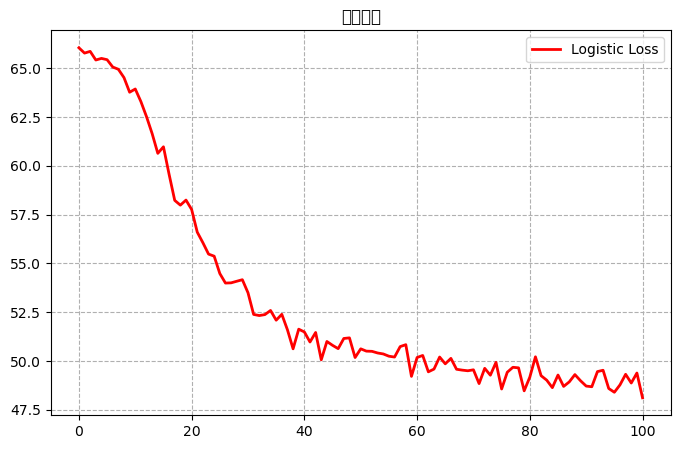

/tmp/ipykernel_13484/1349443593.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.7292, device='cuda:0')
acc_test_each_k: tensor(0.7292, device='cuda:0')
549 3301
549 3301


/tmp/ipykernel_13484/1349443593.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.7833, device='cuda:0')
Training Epoch: 0, total loss: 49.317700
total_train_accuracy: tensor(0.7625, device='cuda:0')
Training Epoch: 1, total loss: 49.395634
total_train_accuracy: tensor(0.7708, device='cuda:0')
Training Epoch: 2, total loss: 49.317727
total_train_accuracy: tensor(0.7813, device='cuda:0')
Training Epoch: 3, total loss: 49.288593
total_train_accuracy: tensor(0.8042, device='cuda:0')
Training Epoch: 4, total loss: 48.620746
total_train_accuracy: tensor(0.7875, device='cuda:0')
Training Epoch: 5, total loss: 49.194774
total_train_accuracy: tensor(0.7833, device='cuda:0')
Training Epoch: 6, total loss: 48.760252
total_train_accuracy: tensor(0.8063, device='cuda:0')
Training Epoch: 7, total loss: 48.428776
total_train_accuracy: tensor(0.7938, device='cuda:0')
Training Epoch: 8, total loss: 48.840480
total_train_accuracy: tensor(0.8146, device='cuda:0')
Training Epoch: 9, total loss: 48.211913
total_train_accuracy: tensor(0.7958, device='cuda:

total_train_accuracy: tensor(0.8375, device='cuda:0')
Training Epoch: 86, total loss: 47.002965
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 87, total loss: 46.595975
total_train_accuracy: tensor(0.8208, device='cuda:0')
Training Epoch: 88, total loss: 47.511400
total_train_accuracy: tensor(0.8229, device='cuda:0')
Training Epoch: 89, total loss: 47.293609
total_train_accuracy: tensor(0.8125, device='cuda:0')
Training Epoch: 90, total loss: 47.890634
total_train_accuracy: tensor(0.8229, device='cuda:0')
Training Epoch: 91, total loss: 47.687389
total_train_accuracy: tensor(0.8146, device='cuda:0')
Training Epoch: 92, total loss: 47.790743
total_train_accuracy: tensor(0.8000, device='cuda:0')
Training Epoch: 93, total loss: 47.911306
total_train_accuracy: tensor(0.8292, device='cuda:0')
Training Epoch: 94, total loss: 47.529689
total_train_accuracy: tensor(0.8458, device='cuda:0')
Training Epoch: 95, total loss: 46.518107
total_train_accuracy: tensor(0.8208, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

total_train_accuracy: tensor(0.8375, device='cuda:0')
Training Epoch: 100, total loss: 46.814688
the  1  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

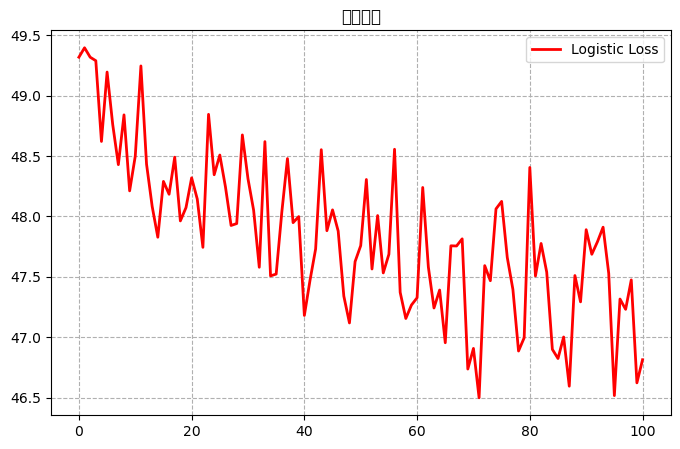

/tmp/ipykernel_13484/1349443593.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.7708, device='cuda:0')
acc_test_each_k: tensor(0.7708, device='cuda:0')
549 3301
549 3301


/tmp/ipykernel_13484/1349443593.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.8354, device='cuda:0')
Training Epoch: 0, total loss: 47.183808
total_train_accuracy: tensor(0.8146, device='cuda:0')
Training Epoch: 1, total loss: 47.594498
total_train_accuracy: tensor(0.8208, device='cuda:0')
Training Epoch: 2, total loss: 47.119324
total_train_accuracy: tensor(0.8396, device='cuda:0')
Training Epoch: 3, total loss: 46.902019
total_train_accuracy: tensor(0.8250, device='cuda:0')
Training Epoch: 4, total loss: 46.889058
total_train_accuracy: tensor(0.8146, device='cuda:0')
Training Epoch: 5, total loss: 47.870790
total_train_accuracy: tensor(0.8271, device='cuda:0')
Training Epoch: 6, total loss: 47.839035
total_train_accuracy: tensor(0.8333, device='cuda:0')
Training Epoch: 7, total loss: 47.243010
total_train_accuracy: tensor(0.8313, device='cuda:0')
Training Epoch: 8, total loss: 47.378875
total_train_accuracy: tensor(0.8333, device='cuda:0')
Training Epoch: 9, total loss: 47.197437
total_train_accuracy: tensor(0.8417, device='cuda:

total_train_accuracy: tensor(0.8604, device='cuda:0')
Training Epoch: 86, total loss: 45.899755
total_train_accuracy: tensor(0.8563, device='cuda:0')
Training Epoch: 87, total loss: 46.212898
total_train_accuracy: tensor(0.8583, device='cuda:0')
Training Epoch: 88, total loss: 46.174479
total_train_accuracy: tensor(0.8563, device='cuda:0')
Training Epoch: 89, total loss: 46.109115
total_train_accuracy: tensor(0.8458, device='cuda:0')
Training Epoch: 90, total loss: 46.802090
total_train_accuracy: tensor(0.8354, device='cuda:0')
Training Epoch: 91, total loss: 46.541770
total_train_accuracy: tensor(0.8250, device='cuda:0')
Training Epoch: 92, total loss: 46.965537
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 93, total loss: 46.252458
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 94, total loss: 46.196954
total_train_accuracy: tensor(0.8625, device='cuda:0')
Training Epoch: 95, total loss: 45.889354
total_train_accuracy: tensor(0.8417, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOG

total_train_accuracy: tensor(0.8542, device='cuda:0')
Training Epoch: 100, total loss: 46.180461
the  2  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

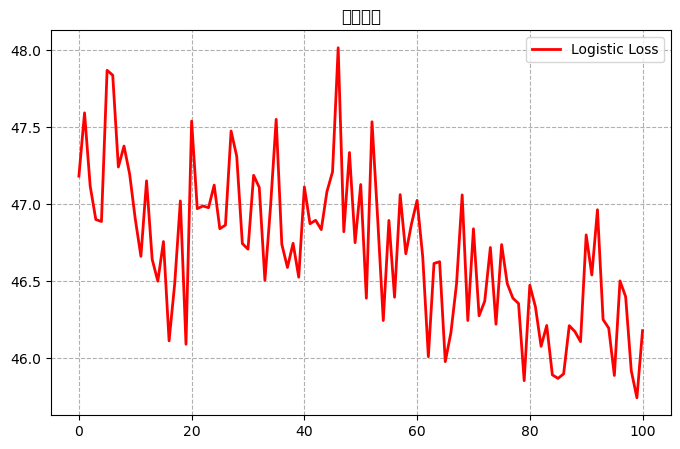

/tmp/ipykernel_13484/1349443593.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.7708, device='cuda:0')
acc_test_each_k: tensor(0.7708, device='cuda:0')
549 3301
549 3301


/tmp/ipykernel_13484/1349443593.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.8333, device='cuda:0')
Training Epoch: 0, total loss: 46.690141
total_train_accuracy: tensor(0.8500, device='cuda:0')
Training Epoch: 1, total loss: 46.370379
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 2, total loss: 46.306640
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 3, total loss: 46.132684
total_train_accuracy: tensor(0.8625, device='cuda:0')
Training Epoch: 4, total loss: 45.706604
total_train_accuracy: tensor(0.8625, device='cuda:0')
Training Epoch: 5, total loss: 46.068587
total_train_accuracy: tensor(0.8500, device='cuda:0')
Training Epoch: 6, total loss: 46.311446
total_train_accuracy: tensor(0.8542, device='cuda:0')
Training Epoch: 7, total loss: 46.258330
total_train_accuracy: tensor(0.8625, device='cuda:0')
Training Epoch: 8, total loss: 46.054553
total_train_accuracy: tensor(0.8500, device='cuda:0')
Training Epoch: 9, total loss: 46.206841
total_train_accuracy: tensor(0.8583, device='cuda:

total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 86, total loss: 44.126477
total_train_accuracy: tensor(0.9083, device='cuda:0')
Training Epoch: 87, total loss: 44.644300
total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 88, total loss: 43.710900
total_train_accuracy: tensor(0.9313, device='cuda:0')
Training Epoch: 89, total loss: 44.312384
total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 90, total loss: 43.986682
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 91, total loss: 43.720557
total_train_accuracy: tensor(0.8896, device='cuda:0')
Training Epoch: 92, total loss: 44.920399
total_train_accuracy: tensor(0.9083, device='cuda:0')
Training Epoch: 93, total loss: 44.410417
total_train_accuracy: tensor(0.9208, device='cuda:0')
Training Epoch: 94, total loss: 44.364484
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 95, total loss: 43.804778
total_train_accuracy: tensor(0.9292, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 100, total loss: 43.253618
the  3  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/py

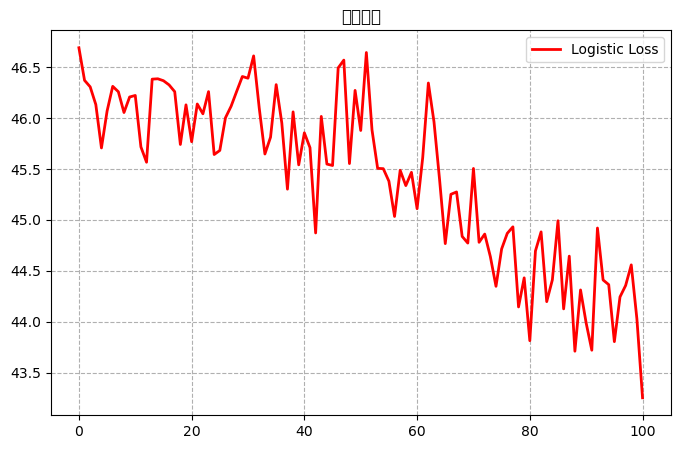

/tmp/ipykernel_13484/1349443593.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.8958, device='cuda:0')
acc_test_each_k: tensor(0.8958, device='cuda:0')
549 3301
549 3301


/tmp/ipykernel_13484/1349443593.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.8917, device='cuda:0')
Training Epoch: 0, total loss: 44.837680
total_train_accuracy: tensor(0.9167, device='cuda:0')
Training Epoch: 1, total loss: 44.556737
total_train_accuracy: tensor(0.9104, device='cuda:0')
Training Epoch: 2, total loss: 44.352998
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 3, total loss: 43.468390
total_train_accuracy: tensor(0.9271, device='cuda:0')
Training Epoch: 4, total loss: 44.081190
total_train_accuracy: tensor(0.9208, device='cuda:0')
Training Epoch: 5, total loss: 44.254702
total_train_accuracy: tensor(0.9333, device='cuda:0')
Training Epoch: 6, total loss: 44.188207
total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 7, total loss: 43.831174
total_train_accuracy: tensor(0.9104, device='cuda:0')
Training Epoch: 8, total loss: 44.268631
total_train_accuracy: tensor(0.9333, device='cuda:0')
Training Epoch: 9, total loss: 44.117632
total_train_accuracy: tensor(0.9208, device='cuda:

total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 86, total loss: 43.649135
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 87, total loss: 43.394984
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 88, total loss: 43.682375
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 89, total loss: 43.269933
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 90, total loss: 43.743956
total_train_accuracy: tensor(0.9188, device='cuda:0')
Training Epoch: 91, total loss: 44.252778
total_train_accuracy: tensor(0.9417, device='cuda:0')
Training Epoch: 92, total loss: 43.393466
total_train_accuracy: tensor(0.9417, device='cuda:0')
Training Epoch: 93, total loss: 43.339283
total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 94, total loss: 43.356591
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 95, total loss: 43.597299
total_train_accuracy: tensor(0.9375, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 100, total loss: 43.653454
the  4  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

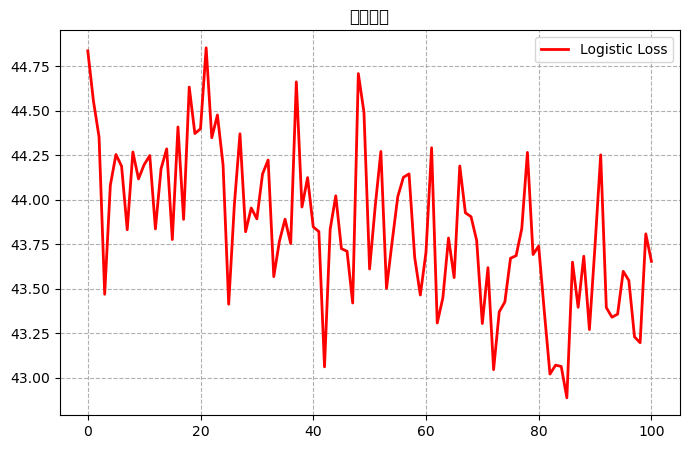

/tmp/ipykernel_13484/1349443593.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.8750, device='cuda:0')
acc_test_each_k: tensor(0.8750, device='cuda:0')
549 3301
549 3301


/tmp/ipykernel_13484/1349443593.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.9167, device='cuda:0')
Training Epoch: 0, total loss: 44.274698
total_train_accuracy: tensor(0.9063, device='cuda:0')
Training Epoch: 1, total loss: 44.535712
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 2, total loss: 44.175226
total_train_accuracy: tensor(0.9125, device='cuda:0')
Training Epoch: 3, total loss: 44.351610
total_train_accuracy: tensor(0.8979, device='cuda:0')
Training Epoch: 4, total loss: 44.991002
total_train_accuracy: tensor(0.9042, device='cuda:0')
Training Epoch: 5, total loss: 44.610821
total_train_accuracy: tensor(0.9333, device='cuda:0')
Training Epoch: 6, total loss: 43.656903
total_train_accuracy: tensor(0.9167, device='cuda:0')
Training Epoch: 7, total loss: 44.153630
total_train_accuracy: tensor(0.9104, device='cuda:0')
Training Epoch: 8, total loss: 44.480238
total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 9, total loss: 43.610119
total_train_accuracy: tensor(0.9229, device='cuda:

total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 86, total loss: 43.146479
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 87, total loss: 43.208556
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 88, total loss: 43.165345
total_train_accuracy: tensor(0.9125, device='cuda:0')
Training Epoch: 89, total loss: 44.317131
total_train_accuracy: tensor(0.8979, device='cuda:0')
Training Epoch: 90, total loss: 44.738929
total_train_accuracy: tensor(0.9417, device='cuda:0')
Training Epoch: 91, total loss: 43.689451
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 92, total loss: 43.367857
total_train_accuracy: tensor(0.9208, device='cuda:0')
Training Epoch: 93, total loss: 44.020220
total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 94, total loss: 43.828346
total_train_accuracy: tensor(0.9479, device='cuda:0')
Training Epoch: 95, total loss: 43.266625
total_train_accuracy: tensor(0.9125, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOG

total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 100, total loss: 43.364452
the  5  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

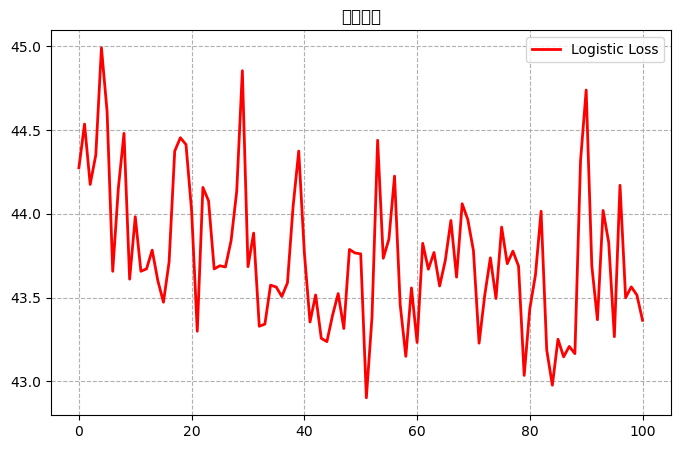

/tmp/ipykernel_13484/1349443593.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.9792, device='cuda:0')
acc_test_each_k: tensor(0.9792, device='cuda:0')
549 3301
549 3301


/tmp/ipykernel_13484/1349443593.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.9250, device='cuda:0')
Training Epoch: 0, total loss: 43.965483
total_train_accuracy: tensor(0.9417, device='cuda:0')
Training Epoch: 1, total loss: 43.408845
total_train_accuracy: tensor(0.9208, device='cuda:0')
Training Epoch: 2, total loss: 43.988701
total_train_accuracy: tensor(0.9188, device='cuda:0')
Training Epoch: 3, total loss: 44.105228
total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 4, total loss: 44.120763
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 5, total loss: 43.404144
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 6, total loss: 43.371563
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 7, total loss: 43.146531
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 8, total loss: 42.962747
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 9, total loss: 43.582294
total_train_accuracy: tensor(0.9375, device='cuda:

total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 86, total loss: 43.377102
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 87, total loss: 43.532824
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 88, total loss: 43.403821
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 89, total loss: 43.226384
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 90, total loss: 43.412755
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 91, total loss: 43.455240
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 92, total loss: 42.655094
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 93, total loss: 43.348030
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 94, total loss: 43.294647
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 95, total loss: 43.022777
total_train_accuracy: tensor(0.9375, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

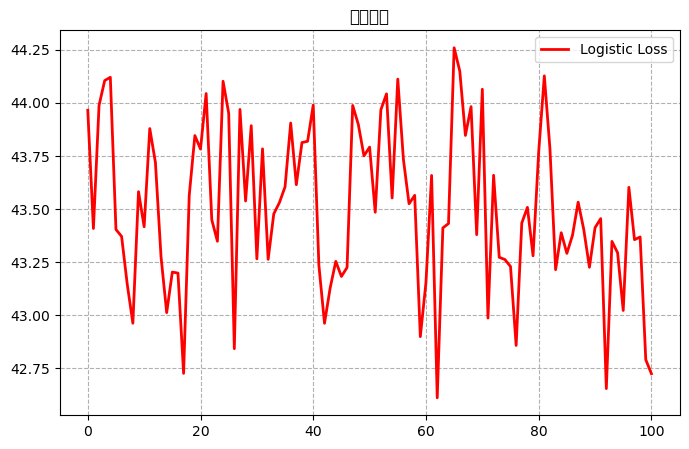

/tmp/ipykernel_13484/1349443593.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 3301
549 3301


/tmp/ipykernel_13484/1349443593.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 0, total loss: 43.347507
total_train_accuracy: tensor(0.9229, device='cuda:0')
Training Epoch: 1, total loss: 43.875095
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 2, total loss: 43.086556
total_train_accuracy: tensor(0.9313, device='cuda:0')
Training Epoch: 3, total loss: 43.635424
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 4, total loss: 43.430088
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 5, total loss: 43.232539
total_train_accuracy: tensor(0.9250, device='cuda:0')
Training Epoch: 6, total loss: 43.853536
total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 7, total loss: 43.694634
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 8, total loss: 43.711101
total_train_accuracy: tensor(0.9229, device='cuda:0')
Training Epoch: 9, total loss: 43.801904
total_train_accuracy: tensor(0.9500, device='cuda:

total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 86, total loss: 43.092938
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 87, total loss: 43.004529
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 88, total loss: 42.368086
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 89, total loss: 43.099372
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 90, total loss: 42.972331
total_train_accuracy: tensor(0.9250, device='cuda:0')
Training Epoch: 91, total loss: 43.789546
total_train_accuracy: tensor(0.9479, device='cuda:0')
Training Epoch: 92, total loss: 43.288723
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 93, total loss: 43.360796
total_train_accuracy: tensor(0.9125, device='cuda:0')
Training Epoch: 94, total loss: 44.048199
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 95, total loss: 42.837318
total_train_accuracy: tensor(0.9250, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 100, total loss: 43.741695
the  7  epoch ends


/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Generic family 'sans-serif' not found because none of the 

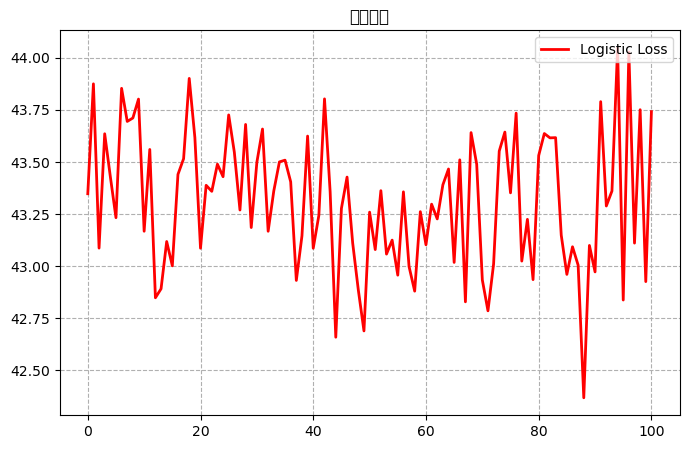

/tmp/ipykernel_13484/1349443593.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.8958, device='cuda:0')
acc_test_each_k: tensor(0.8958, device='cuda:0')
549 3301
549 3301


/tmp/ipykernel_13484/1349443593.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 0, total loss: 43.469347
total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 1, total loss: 43.646541
total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 2, total loss: 43.609265
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 3, total loss: 43.360970
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 4, total loss: 43.550777
total_train_accuracy: tensor(0.9208, device='cuda:0')
Training Epoch: 5, total loss: 43.712341
total_train_accuracy: tensor(0.9188, device='cuda:0')
Training Epoch: 6, total loss: 44.179018
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 7, total loss: 43.571590
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 8, total loss: 43.589264
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 9, total loss: 43.571405
total_train_accuracy: tensor(0.9313, device='cuda:

total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 86, total loss: 42.825571
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 87, total loss: 43.024308
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 88, total loss: 43.041045
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 89, total loss: 43.025637
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 90, total loss: 42.606195
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 91, total loss: 43.521300
total_train_accuracy: tensor(0.9479, device='cuda:0')
Training Epoch: 92, total loss: 43.182413
total_train_accuracy: tensor(0.9333, device='cuda:0')
Training Epoch: 93, total loss: 43.427279
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 94, total loss: 43.110542
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 95, total loss: 42.638209
total_train_accuracy: tensor(0.9417, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOG

total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 100, total loss: 42.590542
the  8  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

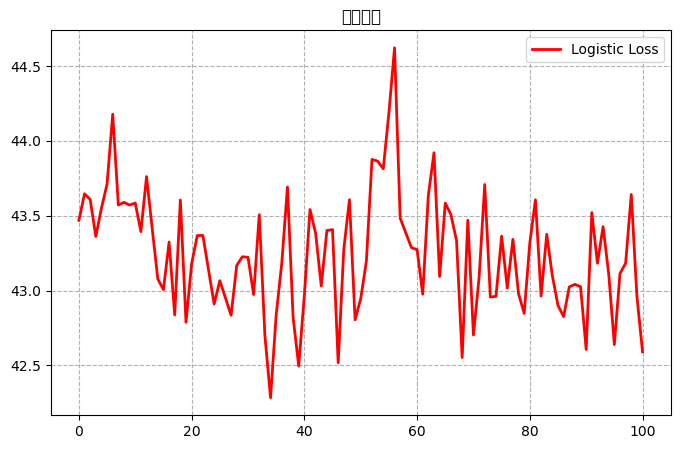

/tmp/ipykernel_13484/1349443593.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.9792, device='cuda:0')
acc_test_each_k: tensor(0.9792, device='cuda:0')
549 3301
549 3301


/tmp/ipykernel_13484/1349443593.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 0, total loss: 42.936749
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 1, total loss: 42.920865
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 2, total loss: 43.059250
total_train_accuracy: tensor(0.9271, device='cuda:0')
Training Epoch: 3, total loss: 43.853752
total_train_accuracy: tensor(0.9417, device='cuda:0')
Training Epoch: 4, total loss: 43.300712
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 5, total loss: 42.782838
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 6, total loss: 43.206450
total_train_accuracy: tensor(0.9229, device='cuda:0')
Training Epoch: 7, total loss: 43.873911
total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 8, total loss: 43.377886
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 9, total loss: 42.827536
total_train_accuracy: tensor(0.9354, device='cuda:

total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 86, total loss: 43.346507
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 87, total loss: 42.719143
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 88, total loss: 42.613064
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 89, total loss: 43.005382
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 90, total loss: 43.057279
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 91, total loss: 43.595585
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 92, total loss: 42.737574
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 93, total loss: 42.908711
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 94, total loss: 43.067691
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 95, total loss: 42.852859
total_train_accuracy: tensor(0.9479, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

total_train_accuracy: tensor(0.9188, device='cuda:0')
Training Epoch: 100, total loss: 44.020038
the  9  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

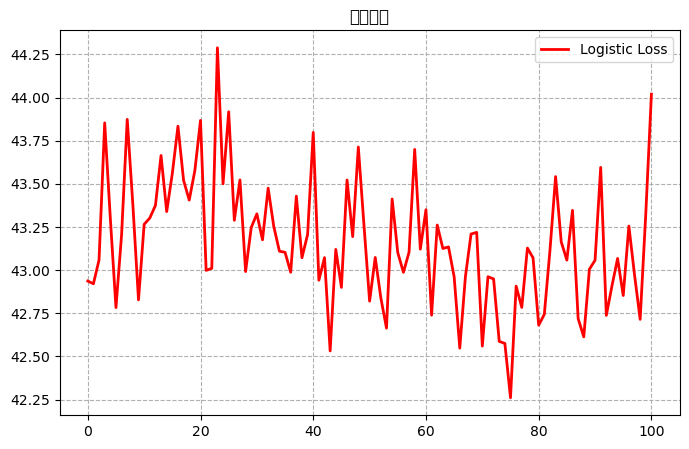

/tmp/ipykernel_13484/1349443593.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_13484/1349443593.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.9792, device='cuda:0')
acc_test_each_k: tensor(0.9792, device='cuda:0')
[tensor(0.7292, device='cuda:0'), tensor(0.7708, device='cuda:0'), tensor(0.7708, device='cuda:0'), tensor(0.8958, device='cuda:0'), tensor(0.8750, device='cuda:0'), tensor(0.9792, device='cuda:0'), tensor(1., device='cuda:0'), tensor(0.8958, device='cuda:0'), tensor(0.9792, device='cuda:0'), tensor(0.9792, device='cuda:0')]
[array(0.7291667, dtype=float32), array(0.7708334, dtype=float32), array(0.7708334, dtype=float32), array(0.8958334, dtype=float32), array(0.875, dtype=float32), array(0.9791667, dtype=float32), array(1., dtype=float32), array(0.8958334, dtype=float32), array(0.9791667, dtype=float32), array(0.9791667, dtype=float32)]
acc_test_metrics: 0.8875


In [4]:
model=modela
K=10
test_metrics=[]
train_loss_total_list=[]
for ki in range(K):
    trainset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv',K=K, n_class=nfm_config['n_class'],ki=ki,  typ='train', transform=None, rand=True)
    valset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv', K=K,n_class=nfm_config['n_class'],ki=ki,  typ='val', transform=None, rand=True)
    train_loader = data.DataLoader(
         dataset=trainset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size'],
         shuffle=True)
    val_loader = data.DataLoader(
         dataset=valset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size']
        
     )
    
    model_path='models/ConvAttMLP_10layers_add_without_res/'
    #BATCH_SIZE=batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=nfm_config['lr'], weight_decay=nfm_config['l2_regularization'])
    #total = 0
    
    
    loss_func=torch.nn.CrossEntropyLoss()
    
    num=0
   
    
    epoches=101
    for epoch_id in range(epoches):
          
        
        
        train_loss_total,acc_train=train_epoch(model,train_loader,nfm_config['batch_size'],optimizer,loss_func)
        train_loss_total_list.append(train_loss_total)#
        if epoch_id %20==0:
            num=num+1
            #path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pkl')
            #torch.save(model.state_dict(),path)
            # 保存模型
            
            path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pt')##################pt
            torch.save(model.state_dict(),path)
            #torch.save(model.state_dict(),path)
    print("the ",ki," epoch ends")
    plotLoss(train_loss_total_list,epoches)
    train_loss_total_list=[]
    acc_test=val_epoch(model,val_loader,nfm_config['batch_size'],optimizer)
    print("acc_test_each_k:",acc_test)
    test_metrics.append(acc_test)

print(test_metrics)
#test_metrics=test_metrics.tolist()
test_metrics=[x.cpu().detach().numpy() for x in test_metrics]
print(test_metrics)
acc_test_metrics=np.mean(test_metrics) 
print("acc_test_metrics:",acc_test_metrics)
       


In [5]:
input_num=3300
def evaluate_model(test_dl, model,input_num): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 


In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt

def plotAcc(len_list,acc_score_list):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(8, 5))
    #x=[i for i in range(lenth)]
    #acc_train=acc_train.cpu()
    #acc_test=acc_test.cpu()
    plt.plot(len_list, acc_score_list, 'r-', mec='k', label='Logistic Loss', lw=2)
    #plt.plot(x,acc_train,'b-',mec='k',label='accuracy Train',lw=2)
    #plt.plot(x,acc_test,'g-',mec='k',label='accuracy Test',lw=2)
    #plt.plot(x, y_01, 'g-', mec='k', label='0/1 Loss', lw=2)
    #plt.plot(x, y_hinge, 'b-',mec='k', label='Hinge Loss', lw=2)
    #plt.plot(x, boost, 'm--',mec='k', label='Adaboost Loss',lw=2)
    plt.grid(True, ls='--')
    plt.legend(loc='upper right')
    plt.title('损失函数')
    plt.show()
    
testset_guan = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoguan/test_info.csv')
   
test_loader_guan = data.DataLoader(
         dataset=testset_guan,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size']
        
     )

testset_qiu = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu/test_info.csv')
   
test_loader_qiu = data.DataLoader(
         dataset=testset_qiu,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size']
        
     )
input_num=3300

68 3301
70 3301


models/ConvAttMLP_10layers_add__/MLP210.pt


/tmp/ipykernel_13070/2371833823.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or source

models/ConvAttMLP_10layers_add__/MLP110.pt
models/ConvAttMLP_10layers_add__/MLP310.pt


/tmp/ipykernel_13070/2371833823.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or source

models/ConvAttMLP_10layers_add__/MLP610.pt
models/ConvAttMLP_10layers_add__/MLP510.pt
models/ConvAttMLP_10layers_add__/MLP410.pt


/tmp/ipykernel_13070/2371833823.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or source

0.890625
4 models/ConvAttMLP_10layers_add__/MLP510.pt 0.890625


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

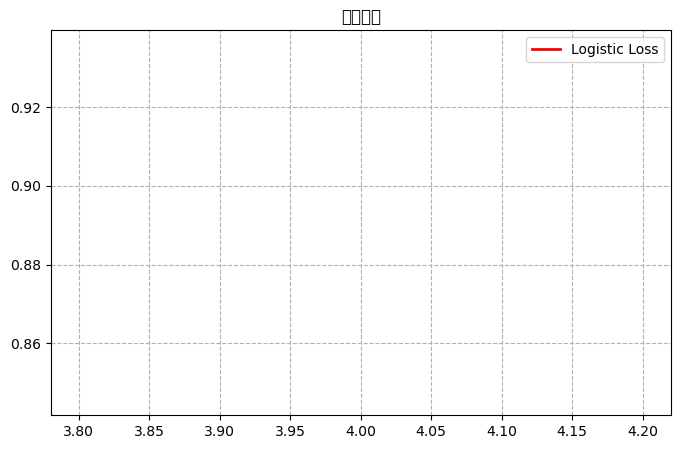

In [7]:
#from PlotCurves import plotGraph,plotLoss,plotMatrix
#from train_val_test import evaluate_model
import os
#path_dir='dataset/qiuguan/origin_800/non_encode_aug/para0.6_0.4_0.3_0.1/'


#path_dir='dataset/qiuguan/origin_800/non_encode_aug/aug_model/para_gause_0.4_0.2_0.6_0.2/'
path_dir='models/ConvAttMLP_10layers_add__/'
#mlp=MLP()
mlp=ConvAttMLP_10layers_add__()
path_list=[]
acc_score_list=[]
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
pos=0
for parent, _, files in os.walk(path_dir):
    pathes=files
for path_ in pathes:
    if path_.startswith('MLP'):  # 去除隐藏文件


        
        path=os.path.join(path_dir,path_)
        print(path)
        mlp.load_state_dict(torch.load(path),strict=False)
        mlp.cuda()

        net=mlp
        actuals,predictions,acc_test=evaluate_model(test_loader_guan,net,input_num)

       
        target_list=actuals 
        pred_list=predictions 
      
        y_true=target_list 
        y_pred=pred_list 
      

        acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 

        acc_score_list.append(acc_score)
        path_list.append(path)
        pos=pos+1
max_guan=max(acc_score_list)
print(max_guan)
#max_len=len(max_qiu)
max_guan_list=[]
max_guan_len_list=[]
for i,score in enumerate(acc_score_list):
    
    if score==max_guan:
        print(i,path_list[i],score)
        
        max_guan_list.append(score)
        max_guan_len_list.append(i)
#lenth=len(acc_score_list)

plotAcc(max_guan_len_list,max_guan_list)

models/ConvAttMLP_10layers_add__//MLP210.pt
models/ConvAttMLP_10layers_add__//MLP110.pt
models/ConvAttMLP_10layers_add__//MLP310.pt
models/ConvAttMLP_10layers_add__//MLP610.pt


/tmp/ipykernel_13070/2371833823.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or source

models/ConvAttMLP_10layers_add__//MLP510.pt
models/ConvAttMLP_10layers_add__//MLP410.pt
0.96875
1 models/ConvAttMLP_10layers_add__//MLP110.pt 0.96875
2 models/ConvAttMLP_10layers_add__//MLP310.pt 0.96875
3 models/ConvAttMLP_10layers_add__//MLP610.pt 0.96875
4 models/ConvAttMLP_10layers_add__//MLP510.pt 0.96875
5 models/ConvAttMLP_10layers_add__//MLP410.pt 0.96875


/tmp/ipykernel_13070/2371833823.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13070/2371833823.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or source

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

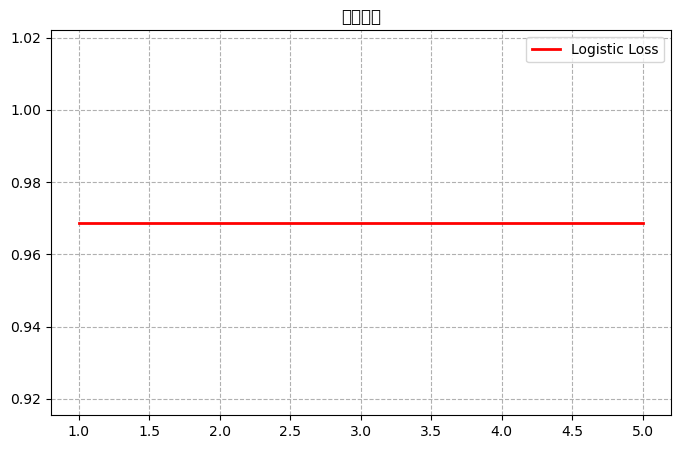

In [8]:
path_dir='models/ConvAttMLP_10layers_add__//'
#mlp=MLP()
mlp=ConvAttMLP_10layers_add__()
acc_score_list=[]
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
pos=0
path_list=[]
for parent, _, files in os.walk(path_dir):
    pathes=files
for path_ in pathes:
    if path_.startswith('MLP'):  # 去除隐藏文件


        #print(path)
        path=os.path.join(path_dir,path_)
        print(path)
        mlp.load_state_dict(torch.load(path),strict=False)
        mlp.cuda()

        net=mlp
        actuals,predictions,acc_test=evaluate_model(test_loader_qiu,net,input_num)

       
        target_list=actuals 
        pred_list=predictions 
      
        y_true=target_list 
        y_pred=pred_list 
      

        acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 

        acc_score_list.append(acc_score)
        path_list.append(path)
        pos=pos+1
        
max_qiu=max(acc_score_list)
print(max_qiu)
#max_len=len(max_qiu)
max_qiu_list=[]
max_qiu_len_list=[]


for i,score in enumerate(acc_score_list):
    
    if score==max_qiu:
        print(i,path_list[i],score)
        
        max_qiu_list.append(score)
        max_qiu_len_list.append(i)
#lenth=len(acc_score_list)

plotAcc(max_qiu_len_list,max_qiu_list)

ConvAttMLP_10layers_add_withou_res(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=1100, bias=True)
  (fc11): Linear(in_features=1100, out_features=1100, bias=True)
  (bn1): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1100, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(3300, eps=1e-05, momentum

/tmp/ipykernel_13484/385248990.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13484/385248990.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets,dtype=torch.float)
/tmp/ipykernel_13484/385248990.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_13484/385248990.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTens

f1_score:  %.4f 0.8145530195065799
accuracy_score: 0.8115942028985508
recall_score: 0.8170090258325552
pre_recall: 0.8352769235122177
n_classes: 9


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

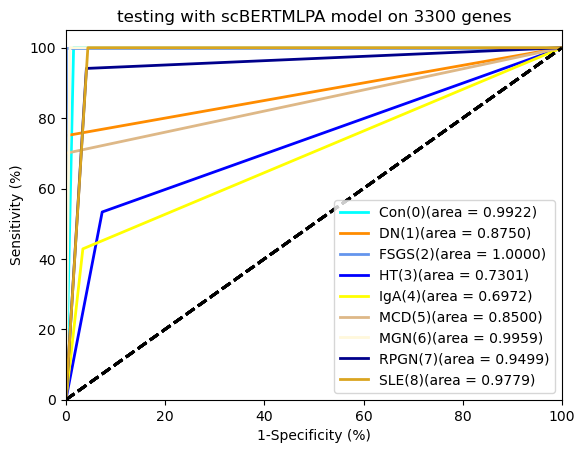

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

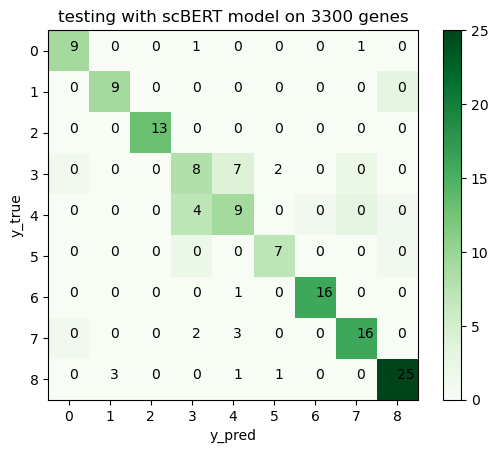

In [11]:
import torch

#功能：加载保存到path中的各层参数到神经网络

#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP610.pkl'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP9110.pkl'

#path='models/ConvAttMLP/MLP610.pt'

path='models/ConvAttMLP_10layers_add_without_res////MLP410.pt'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP10910.pkl'
#nfm=NFM(nfm_config)
#mlp=MLP()
mlp=ConvAttMLP_10layers_add_withou_res()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    #plt.title('testing on kidney tubules with F800 without augment') 
    #plt.title('testing with ConvAttMLPA model on 3300 genes')  
    plt.title('testing with scBERTMLPA model on 3300 genes')  

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 

#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('testing with scBERT model on 3300 genes')      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show()

In [14]:
import torch

#功能：加载保存到path中的各层参数到神经网络

#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP610.pkl'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP9110.pkl'

path='models/ConvAttMLP/MLP610.pt'

#path='models/ConvAtt_without_MLP/MLP610.pt'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP10910.pkl'
#nfm=NFM(nfm_config)
#mlp=MLP()
mlp=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    #plt.title('testing on kidney tubules with F800 without augment') 
    plt.title('testing with stBERTMLPA model on 3300 genes')   

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 

#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('import torch')

#功能：加载保存到path中的各层参数到神经网络

#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP610.pkl'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP9110.pkl'

path='models/ConvAttMLP/MLP610.pt'

#path='models/ConvAtt_without_MLP/MLP610.pt'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP10910.pkl'
#nfm=NFM(nfm_config)
#mlp=MLP()
mlp=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    #plt.title('testing on kidney tubules with F800 without augment') 
    plt.title('testing with ConvAttMLPA model on 3300 genes')   

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 

#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('test on 3300 genes')      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show('import torch')

#功能：加载保存到path中的各层参数到神经网络

#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP610.pkl'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP9110.pkl'

path='models/ConvAttMLP/MLP610.pt'

#path='models/ConvAtt_without_MLP/MLP610.pt'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP10910.pkl'
#nfm=NFM(nfm_config)
#mlp=MLP()
mlp=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    #plt.title('testing on kidney tubules with F800 without augment') 
    plt.title('testing with scBERTMLPA model on 3300 genes')   

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 

#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('test with scBERTMLPA on 3300 genes')      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show()     
# 显示数据 

RuntimeError: Error(s) in loading state_dict for ConvAttMLP:
	size mismatch for bn7.weight: copying a param with shape torch.Size([1100]) from checkpoint, the shape in current model is torch.Size([2200]).
	size mismatch for bn7.bias: copying a param with shape torch.Size([1100]) from checkpoint, the shape in current model is torch.Size([2200]).
	size mismatch for bn7.running_mean: copying a param with shape torch.Size([1100]) from checkpoint, the shape in current model is torch.Size([2200]).
	size mismatch for bn7.running_var: copying a param with shape torch.Size([1100]) from checkpoint, the shape in current model is torch.Size([2200]).

ConvAttMLP(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=1100, bias=True)
  (bn1): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1100, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn4): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn5): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=F

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

f1_score:  %.4f 0.905846553010994
accuracy_score: 0.9130434782608695
recall_score: 0.903781512605042
pre_recall: 0.9188516324481236
n_classes: 9


/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:152: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


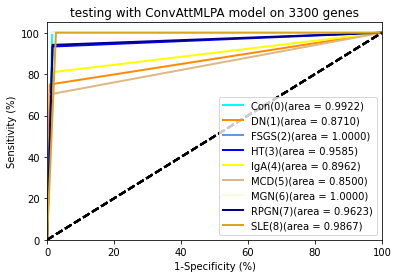

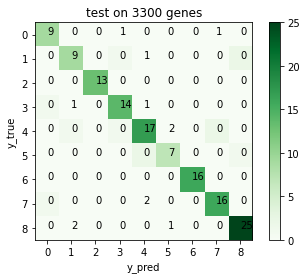

In [5]:
import torch

#功能：加载保存到path中的各层参数到神经网络

#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP610.pkl'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP9110.pkl'

#path='models/ConvAttMLP/MLP610.pt'

#path='models/ConvAtt_without_MLP/MLP610.pt'
path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP10910.pkl'
#nfm=NFM(nfm_config)
#mlp=MLP()
mlp=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    #plt.title('testing on kidney tubules with F800 without augment') 
    plt.title('testing with ConvAttMLPA model on 3300 genes')   

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 

#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('test on 3300 genes')      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show()

In [12]:
import torch
import torchmetrics

def test_model(model, test_loader, device, num_classes):
    model.eval()  # 设置模型为评估模式
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    precision = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='macro').to(device)
    recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='macro').to(device)
    f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device)

    with torch.no_grad():  # 禁用梯度计算以加速推理
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device).float()  # 确保输入为 float 类型
            labels = labels.to(device)

            # 如果 labels 是 one-hot 编码，则通过 argmax 转换为类别索引
            if labels.dim() == 2 and labels.size(1) == num_classes:
                labels = torch.argmax(labels, dim=1)

            # 预测
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)  # 获取每个样本的预测类别索引

            # 检查 preds 和 labels 形状是否匹配
            print(f"Preds shape: {preds.shape}, Labels shape: {labels.shape}")

            # 更新指标
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

    # 计算最终的指标
    acc = accuracy.compute().item()
    prec = precision.compute().item()
    rec = recall.compute().item()
    f1_score = f1.compute().item()

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    return acc, prec, rec, f1_score



In [13]:
path='models/ConvAttMLP_res_concat/MLP610.pt'
mlp=ConvAttMLP_res_concat()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )

test_model(net, test_loader, 'cuda', 9)

ConvAttMLP_res_concat(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=1100, bias=True)
  (bn1): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2200, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn4): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn5): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, 

(0.8405796885490417, 0.8533937931060791, 0.833206295967102, 0.8340438604354858)

In [7]:
import torch

#功能：加载保存到path中的各层参数到神经网络
####################################################ConvAttMLP_new-----------------------------
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP610.pkl'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP9110.pkl'
#path='models/ConvAttMLP_res_concat/MLP610.pt'
path='models/ConvAttMLP_without_Adaptive/MLP610.pt'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP10910.pkl'
#nfm=NFM(nfm_config)
#mlp=MLP()
#mlp=ConvAttMLP_res_concat()
mlp=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )



'''
testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
'''
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    #plt.title('testing on kidney tubules with F800 without augment') 
    plt.title('testing with ConvAttMLPA model on 3300 genes')   

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 

#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('test on 3300 genes')      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show()

RuntimeError: Error(s) in loading state_dict for ConvAttMLP:
	size mismatch for bn7.weight: copying a param with shape torch.Size([1100]) from checkpoint, the shape in current model is torch.Size([2200]).
	size mismatch for bn7.bias: copying a param with shape torch.Size([1100]) from checkpoint, the shape in current model is torch.Size([2200]).
	size mismatch for bn7.running_mean: copying a param with shape torch.Size([1100]) from checkpoint, the shape in current model is torch.Size([2200]).
	size mismatch for bn7.running_var: copying a param with shape torch.Size([1100]) from checkpoint, the shape in current model is torch.Size([2200]).

In [5]:
#find the means for the predicted correctly
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def bool_predict_model(test_dl, model): 
    model.eval()#测试数据稳定
    error_dataset=torch.tensor([0])
    error_dataset=error_dataset.view(1,1)
    predictions, actuals = [], [] 
    num=0
    for i, (inputs,targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        #bi_inputs=Variable(bi_inputs)
        targets = Variable(targets) 
        #print(targets)
        #print('targets:',targets.shape)        
        #targets=targets.argmax(axis=1)  
        #print('targets:',targets.shape)
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        #bi_inputs=torch.tensor(bi_inputs,dtype=torch.float)
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(),targets.cuda() 
        yhat = model(inputs) 
        
        yhat=yhat.argmax(axis=1)
        print('yhat:',yhat.shape)
        
        if targets==yhat:
            return True
        else:
            return False
#find

In [8]:
#find the samples that predicted correctly
import pandas as pd 
test_df=pd.read_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info1.csv',sep=',')
test_df=test_df.iloc[:,1:]
rows,cols=test_df.shape
print(rows,cols)
import torch

#功能：加载保存到path中的各层参数到神经网络

path='models/ConvAttMLP/MLP610.pt'

#nfm=NFM(nfm_config)
#mlp=MLP()
model=ConvAttMLP()
model_lrp=ConvAttMLP_LRP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
# Load the state_dict for both models separately
model.load_state_dict(torch.load(path), strict=False)
model_lrp.load_state_dict(model.state_dict())  # Copying the loaded state dict to model_lrp

model.cuda()
model_lrp.cuda()
#print(model)




model_params = list(model.named_parameters())
#print(nfm_params)
net=model


#testset = KZDatasetPredict(test_df)
''''
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size']
        
     )
'''
false_list=[]
for i in range(rows):
    df_list=test_df.iloc[i,:].tolist()
    print(type(df_list))
    print('df_list:',df_list[-1])
    #print(data_set)
    print('this is data_set')
    data_set = KZDatasetPredict(df_list)
    data_test_loader=data.DataLoader(dataset=data_set,
                                    batch_size=1)
    print(data_test_loader)
    bool_index=bool_predict_model(data_test_loader,model)
    print(bool_index)
    if bool_index==False:
        
        false_list.append(i)
        #test_df=test_df.drop(index=i, inplace=True)
        
for i,aitem in enumerate(false_list):
    test_df.drop(index=i, inplace=True)
print(test_df.shape)   

test_df.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info3.csv')

138 3301
<class 'list'>
df_list: 5.0
this is data_set
data_info: 5.0
labels: [5]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 5.0
this is data_set
data_info: 5.0
labels: [5]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 8.0
this is data_set
data_info: 8.0
labels: [8]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 6.0
this is data_set
data_info: 6.0
labels: [6]
labe

/tmp/ipykernel_16858/1192932608.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_16858/1192932608.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets,dtype=torch.float)


x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 3.0
this is data_set
data_info: 3.0
labels: [3]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 1.0
this is data_set
data_info: 1.0
labels: [1]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 4.0
this is data_set
data_info: 4.0
labels: [4]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 3.0
t

x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 3.0
this is data_set
data_info: 3.0
labels: [3]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 1.0
this is data_set
data_info: 1.0
labels: [1]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 3.0
this is data_set
data_info: 3.0
labels: [3]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 

x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 2.0
this is data_set
data_info: 2.0
labels: [2]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 7.0
this is data_set
data_info: 7.0
labels: [7]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 8.0
this is data_set
data_info: 8.0
labels: [8]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 1.0
t

True
<class 'list'>
df_list: 0.0
this is data_set
data_info: 0.0
labels: [0]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 7.0
this is data_set
data_info: 7.0
labels: [7]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 0.0
this is data_set
data_info: 0.0
labels: [0]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 7.0
this is data_set
data_info: 7.0
labels: [7]
labels.s

x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 8.0
this is data_set
data_info: 8.0
labels: [8]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 3.0
this is data_set
data_info: 3.0
labels: [3]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Size([1, 16, 1])
max_pool: torch.Size([1, 16, 1])
x2: torch.Size([1, 1, 3300])
yhat: torch.Size([1])
True
<class 'list'>
df_list: 6.0
this is data_set
data_info: 6.0
labels: [6]
labels.shape: (1,)
x: torch.Size([1, 3300])
x0: torch.Size([1, 1, 3300])
x2_argpool: torch.Size([1, 16, 3300])
avg_pool: torch.Si

In [15]:
#top_20


#compute mean value of all the correctly predicted samples:
import pandas as pd 
import torch
import numpy as np
test_df=pd.read_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info3.csv',sep=',')
test_df=test_df.iloc[:,1:]
rows,cols=test_df.shape
print(rows,cols)
columns=test_df.columns[:-1].tolist()
#columns=torch.tensor(columns).cuda()#ValueError: too many dimensions 'str'


row_mean=test_df.mean(axis=0)
print(row_mean)
row_mean=row_mean[:-1]#drop off label
row_mean_np=np.array(row_mean).reshape(1,-1)
print(row_mean_np)
row_mean_df=pd.DataFrame(row_mean_np)
print(row_mean_df)
row_mean_df.columns=test_df.columns[:-1]
print(row_mean_df)
row_mean_tensor=torch.from_numpy(row_mean_np).cuda()
row_mean_tensor=torch.tensor(row_mean_tensor,dtype=torch.float)###################################
#去掉行




#compute contribution using the Equ.
import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

path='models/ConvAttMLP/MLP610.pt'

#nfm=NFM(nfm_config)
model=ConvAttMLP()
model_lrp=ConvAttMLP_LRP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
# Load the state_dict for both models separately
model.load_state_dict(torch.load(path), strict=False)
model_lrp.load_state_dict(model.state_dict())  # Copying the loaded state dict to model_lrp

model.cuda()
model_lrp.cuda()











def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    n = len(labels)
    #n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output







import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from innvestigator2 import InnvestigateModel
#from utils import Flatten
model.double()
model.eval()
model.cuda()

inn_model = InnvestigateModel(model_lrp, lrp_exponent=2,
                              method="e-rule",
                              beta=.5)

genes_features=np.array([i for i  in range(9)])#################
genes_features=genes_features.reshape(9,1).tolist()#######################genes_features[i][0]=label

inn_model.cuda()

###[3, 25.353026075712233, tensor([ 182,  879,  103, 2657, 2489,  914, 2437,  180, 2417, 1402, 2344, 2947,
###values=tensor([0.0572, 0.0495, 0.0404, 0.0381, 0.0364, 0.0353, 0.0328, 0.0302, 0.0284,
#        0.0257, 0.0180, 0.0164, 0.0155, 0.0150, 0.0135, 0.0127, 0.0121, 0.0120,
#        0.0114, 0.0107, 0.0107, 0.0104, 0.0100, 0.0100, 0.0099, 0.0091, 0.0091,
#       0.0088, 0.0083, 0.0082, 0.0081, 0.0079, 0.0078, 0.0077, 0.0076, 0.0074,
#       0.0073, 0.0072, 0.0072, 0.0071], dtype=torch.float64),
###indices=tensor([ 182,  879,  103, 2657, 2489,  914, 2437,  180, 2417, 1402, 2344, 2947,
#        2546, 1114,  796, 1111, 2472, 2326, 1274,  932, 2476,  716,  989, 3289,
#        1252, 2053,  785, 2429, 3015, 1585,  975, 1150, 1155,  726,  823, 2303,
#         699,  349, 1792, 1524])), 25.359040192320702, tensor([2489,  826, 1753, 1792,  601, 2303, 1053,  545, 2559,  624, 3256,  762,
#        2666,  182, 1881, 1585,  726, 1367, 2405, 1171, 2947, 2093,   14,  265,
#         716,  180, 1467, 2207, 3223,  349,  277, 2141, 2878, 2427, 2326, 1111,
#         746, 1402, 2150, 1602]), torch.return_types.topk(
#values=tensor([0.0456, 0.0445, 0.0406, 0.0349, 0.0277, 0.0273, 0.0246, 0.0236, 0.0225,
#        0.0221, 0.0213, 0.0200, 0.0185, 0.0182, 0.0181, 0.0153, 0.0151, 0.0142,
##        0.0141, 0.0140, 0.0138, 0.0123, 0.0121, 0.0115, 0.0109, 0.0108, 0.0107,
#        0.0102, 0.0102, 0.0098, 0.0094, 0.0093, 0.0092, 0.0089, 0.0082, 0.0081,
#        0.0080, 0.0080, 0.0079, 0.0076], dtype=torch.float64),
#indices=tensor([2489,  826, 1753, 1792,  601, 2303, 1053,  545, 2559,  624, 3256,  762,
#        2666,  182, 1881, 1585,  726, 1367, 2405, 1171, 2947, 2093,   14,  265,
#         716,  180, 1467, 2207, 3223,  349,  277, 2141, 2878, 2427, 2326, 1111,
#         746, 1402, 2150, 1602]))]

row_mean_tensor=row_mean_tensor.cuda()
#print('batch_size:',batch_size)#=20
evidence_for_class = []
#print("target:",target.shape)
#print('target:',target[3])
# Overlay with noise 
# data[0] += 0.25 * data[0].max() * torch.Tensor(np.random.randn(28*28).reshape(1, 28, 28))
#model_prediction, true_relevance = inn_model.innvestigate(in_tensor=data)
contri_k=[]
contri_k_names=[]
for i in range(9):#10类
    # Unfortunately, we had some issue with freeing pytorch memory, therefore 
    # we need to reevaluate the model separately for every class.
        model_prediction, input_relevance_values = inn_model.innvestigate(in_tensor=row_mean_tensor)
        evidence_for_class.append(input_relevance_values)
        top_k=torch.topk(input_relevance_values,20,largest=True)#################20
        print('top_k:',top_k)
    
        contri_k.append(top_k)
        top_k_indices=top_k.indices.cpu().detach().numpy().tolist()
        print('top_k_indices:',top_k_indices)
        # 将二维列表转换为一维列表
        flattened_indices = [item for sublist in top_k_indices for item in sublist]

        top_k_names=[columns[j] for j in flattened_indices]
        print('top_k_names:',top_k_names)
        contri_k_names.append(top_k_names)
        print('contri_k_names:',contri_k_names)
        
        
contri_k_names_np=np.array(contri_k_names)
print(contri_k_names_np.shape)

contri_k_names_df=pd.DataFrame(contri_k_names_np)
contri_k_names_df.to_csv('results_genes/ConvAttMLP/LRP/contri_20_names_df.csv')
#from chartGPT of the following code
result = set()
for sublist in contri_k_names:
    result = result.union(sublist)

# 或者使用集合的union方法的更简洁写法，使用集合解析
# result = set().union(*list_of_lists)

# 或者使用 | 运算符
# result = set().union(*list_of_lists)

# 将结果转回列表
result_list = list(result)

print(result_list)

import csv
csv_filename = "results_genes/ConvAttMLP/LRP/genes_all_20_mean.csv"

# 使用CSV模块保存列表为CSV文件
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(result_list)

#这将输出所有列表的并集，不包含重复的元素。在这个例子中，结果会是 [1, 2, 3, 4, 5, 6, 7]。你可以根据你的实际需求将这个结果转换为列表或者保留为集合，具体取决于你的应用场景。
#抽取训练集和测试集中的数据

#生成新选取元素的数据集
train_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv'
test_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv'

train_df=pd.read_csv(train_path,sep=',')
train_df1=train_df
print(train_df1.columns)
train_df=train_df.iloc[:,1:]
train_df1=train_df1.iloc[:,1:-1]

columns=result_list
columns.append('label')
print(columns)


train_df2=train_df[columns]
print(train_df2.shape)
train_df2.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/LRP/train_val_info.csv')

test_df=pd.read_csv(test_path,sep=',')

test_df=test_df.iloc[:,1:]



test_df=test_df[columns]
print(test_df.shape)
test_df.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/LRP/test_info.csv')





129 3301
RHOA       11.718654
STX2        7.554857
CISD1       9.574166
WDR11       8.211014
SCYL2       6.843801
             ...    
SULT1A1    10.176426
AMOT       11.457798
CA1         6.462708
GPR35       5.410572
label       4.558140
Length: 3301, dtype: float64
[[11.71865387  7.55485654  9.57416624 ... 11.45779827  6.46270762
   5.41057152]]
        0         1         2         3         4         5         6     \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       7         8         9     ...      3290      3291      3292      3293  \
0  5.549722  4.999493  6.581626  ...  8.137269  6.165143  7.996614  6.371971   

       3294      3295       3296       3297      3298      3299  
0  7.569604  6.658189  10.176426  11.457798  6.462708  5.410572  

[1 rows x 3300 columns]
        RHOA      STX2     CISD1     WDR11     SCYL2   MGC2889    CCDC47  \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       KLF8      CCL1   S

/tmp/ipykernel_16858/1129992561.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row_mean_tensor=torch.tensor(row_mean_tensor,dtype=torch.float)###################################


NotImplementedError: The network contains layers that are currently not supported AdaptiveAvgPool1d(output_size=1)

In [8]:
#compute mean value of all the correctly predicted samples:
import pandas as pd 
import torch
import numpy as np
test_df=pd.read_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info3.csv',sep=',')
test_df=test_df.iloc[:,1:]
rows,cols=test_df.shape
print(rows,cols)
columns=test_df.columns[:-1].tolist()
#columns=torch.tensor(columns).cuda()#ValueError: too many dimensions 'str'


row_mean=test_df.mean(axis=0)
print(row_mean)
row_mean=row_mean[:-1]#drop off label
row_mean_np=np.array(row_mean).reshape(1,-1)
print(row_mean_np)
row_mean_df=pd.DataFrame(row_mean_np)
print(row_mean_df)
row_mean_df.columns=test_df.columns[:-1]
print(row_mean_df)
row_mean_tensor=torch.from_numpy(row_mean_np).cuda()
row_mean_tensor=torch.tensor(row_mean_tensor,dtype=torch.float)###################################
#去掉行




#compute contribution using the Equ.
import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

path='models/ConvAttMLP/MLP610.pt'

#nfm=NFM(nfm_config)
model=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
model.load_state_dict(torch.load(path),strict=False)
model.cuda()

print(model)




model_params = list(model.named_parameters())
#print(nfm_params)
net=model



weight={}
for name,parameters in net.named_parameters():
    print(name,':',parameters.size())
    #names.append(name)
    weight[name]=parameters
print("weight:",weight)
#q
'''
bn0.weight : torch.Size([3300])
bn0.bias : torch.Size([3300])
fc1.weight : torch.Size([2000, 3300])
fc1.bias : torch.Size([2000])
bn1.weight : torch.Size([2000])
bn1.bias : torch.Size([2000])
fc2.weight : torch.Size([100, 2000])
fc2.bias : torch.Size([100])
bn2.weight : torch.Size([100])
bn2.bias : torch.Size([100])
fc3.weight : torch.Size([9, 100])
fc3.bias : torch.Size([9])
bn3.weight : torch.Size([9])
bn3.bias : torch.Size([9])
'''






def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    n = len(labels)
    #n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output







l3=torch.mm(weight['fc3.weight'],weight['fc2.weight'][:,:1100])
print('l3:',l3.shape)
l2=torch.mm(l3,weight['fc1.weight'])
print('l2:',l2.shape)
contri_k=[]
contri_k_names=[]
for i in range(nfm_config['n_class']):
    l1=torch.mm(l2,row_mean_tensor.T)
    uu=l2[i,:]*row_mean_tensor.reshape(3300)
    print(uu.shape)
    top_k=torch.topk(uu,20,largest=True)#################20
    print('top_k:',top_k)
    
    contri_k.append(top_k)
    top_k_indices=top_k.indices.cpu().detach().numpy().tolist()
    print('top_k_indices:',top_k_indices)
    top_k_names=[columns[j] for j in top_k_indices]
    print(top_k_names)
    contri_k_names.append(top_k_names)

contri_k_names_np=np.array(contri_k_names)
print(contri_k_names_np.shape)

contri_k_names_df=pd.DataFrame(contri_k_names_np)
contri_k_names_df.to_csv('results_genes/ConvAttMLP/contri_20_names_df.csv')
#from chartGPT of the following code
result = set()
for sublist in contri_k_names:
    result = result.union(sublist)

# 或者使用集合的union方法的更简洁写法，使用集合解析
# result = set().union(*list_of_lists)

# 或者使用 | 运算符
# result = set().union(*list_of_lists)

# 将结果转回列表
result_list = list(result)

print(result_list)

import csv
csv_filename = "results_genes/ConvAttMLP/genes_all_20_mean.csv"

# 使用CSV模块保存列表为CSV文件
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(result_list)

#这将输出所有列表的并集，不包含重复的元素。在这个例子中，结果会是 [1, 2, 3, 4, 5, 6, 7]。你可以根据你的实际需求将这个结果转换为列表或者保留为集合，具体取决于你的应用场景。
#抽取训练集和测试集中的数据

#生成新选取元素的数据集
train_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv'
test_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv'

train_df=pd.read_csv(train_path,sep=',')
train_df1=train_df
print(train_df1.columns)
train_df=train_df.iloc[:,1:]
train_df1=train_df1.iloc[:,1:-1]

columns=result_list
columns.append('label')
print(columns)


train_df2=train_df[columns]
print(train_df2.shape)
train_df2.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/train_val_info.csv')

test_df=pd.read_csv(test_path,sep=',')

test_df=test_df.iloc[:,1:]



test_df=test_df[columns]
print(test_df.shape)
test_df.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info.csv')





129 3301
RHOA       11.718654
STX2        7.554857
CISD1       9.574166
WDR11       8.211014
SCYL2       6.843801
             ...    
SULT1A1    10.176426
AMOT       11.457798
CA1         6.462708
GPR35       5.410572
label       4.558140
Length: 3301, dtype: float64
[[11.71865387  7.55485654  9.57416624 ... 11.45779827  6.46270762
   5.41057152]]
        0         1         2         3         4         5         6     \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       7         8         9     ...      3290      3291      3292      3293  \
0  5.549722  4.999493  6.581626  ...  8.137269  6.165143  7.996614  6.371971   

       3294      3295       3296       3297      3298      3299  
0  7.569604  6.658189  10.176426  11.457798  6.462708  5.410572  

[1 rows x 3300 columns]
        RHOA      STX2     CISD1     WDR11     SCYL2   MGC2889    CCDC47  \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       KLF8      CCL1   S

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([3300])
top_k: torch.return_types.topk(
values=tensor([25.0690, 22.8064, 22.7217, 21.4464, 21.0584, 19.9567, 17.9271, 17.2110,
        16.9928, 16.9866, 16.8373, 16.5269, 15.4862, 15.4330, 15.2337, 14.9387,
        14.8047, 14.7743, 14.7350, 14.5315], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([1150, 1152,  823, 1818, 1609,  103, 3288,  257, 2711, 2960, 2980,  726,
        2076,  572, 2546, 1643, 1467,  951, 2559, 3238], device='cuda:0'))
top_k_indices: [1150, 1152, 823, 1818, 1609, 103, 3288, 257, 2711, 2960, 2980, 726, 2076, 572, 2546, 1643, 1467, 951, 2559, 3238]
['LHPP', 'LGMN', 'CHP1', 'ZNHIT1', 'CTSG', 'IFI6', 'RGS5', 'CYP2J2', 'CPVL', 'RPS27L', 'TDP2', 'AGL', 'CRABP2', 'ACKR1', 'MST1L', 'VAMP8', 'MEST', 'CHODL', 'TYR', 'MS4A4A']
torch.Size([3300])
top_k: torch.return_types.topk(
values=tensor([28.8737, 25.4811, 23.2466, 22.7512, 20.8991, 20.5893, 20.5677, 20.4039,
        20.1702, 19.5677, 19.0753, 18.2577, 18.1311, 18.1291, 17.6533, 17.0435,
   

(138, 127)


In [9]:
#compute mean value of all the correctly predicted samples:
import pandas as pd 
import torch
import numpy as np
test_df=pd.read_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info3.csv',sep=',')
test_df=test_df.iloc[:,1:]
rows,cols=test_df.shape
print(rows,cols)
columns=test_df.columns[:-1].tolist()
#columns=torch.tensor(columns).cuda()#ValueError: too many dimensions 'str'


row_mean=test_df.mean(axis=0)
print(row_mean)
row_mean=row_mean[:-1]#drop off label
row_mean_np=np.array(row_mean).reshape(1,-1)
print(row_mean_np)
row_mean_df=pd.DataFrame(row_mean_np)
print(row_mean_df)
row_mean_df.columns=test_df.columns[:-1]
print(row_mean_df)
row_mean_tensor=torch.from_numpy(row_mean_np).cuda()
row_mean_tensor=torch.tensor(row_mean_tensor,dtype=torch.float)
#去掉行




#compute contribution using the Equ.
import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

path='models/ConvAttMLP/MLP610.pt'

#nfm=NFM(nfm_config)
model=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
model.load_state_dict(torch.load(path),strict=False)
model.cuda()

print(model)




model_params = list(model.named_parameters())
#print(nfm_params)
net=model



weight={}
for name,parameters in net.named_parameters():
    print(name,':',parameters.size())
    #names.append(name)
    weight[name]=parameters
print("weight:",weight)
#q
'''
bn0.weight : torch.Size([3300])
bn0.bias : torch.Size([3300])
fc1.weight : torch.Size([2000, 3300])
fc1.bias : torch.Size([2000])
bn1.weight : torch.Size([2000])
bn1.bias : torch.Size([2000])
fc2.weight : torch.Size([100, 2000])
fc2.bias : torch.Size([100])
bn2.weight : torch.Size([100])
bn2.bias : torch.Size([100])
fc3.weight : torch.Size([9, 100])
fc3.bias : torch.Size([9])
bn3.weight : torch.Size([9])
bn3.bias : torch.Size([9])
'''






def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    n = len(labels)
    #n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output







l3=torch.mm(weight['fc3.weight'],weight['fc2.weight'][:,:1100])
print('l3:',l3.shape)
l2=torch.mm(l3,weight['fc1.weight'])
print('l2:',l2.shape)
contri_k=[]
contri_k_names=[]
for i in range(nfm_config['n_class']):
    l1=torch.mm(l2,row_mean_tensor.T)
    uu=l2[i,:]*row_mean_tensor.reshape(3300)
    print(uu.shape)
    top_k=torch.topk(uu,20,largest=True)#################20
    print('top_k:',top_k)
    
    contri_k.append(top_k)
    top_k_indices=top_k.indices.cpu().detach().numpy().tolist()
    print('top_k_indices:',top_k_indices)
    top_k_names=[columns[j] for j in top_k_indices]
    print(top_k_names)
    contri_k_names.append(top_k_names)

contri_k_names_np=np.array(contri_k_names)
print(contri_k_names_np.shape)

contri_k_names_df=pd.DataFrame(contri_k_names_np)
contri_k_names_df.to_csv('results_genes/ConvAttMLP/contri_20_names_df.csv')
#from chartGPT of the following code
result = set()
for sublist in contri_k_names:
    result = result.union(sublist)

# 或者使用集合的union方法的更简洁写法，使用集合解析
# result = set().union(*list_of_lists)

# 或者使用 | 运算符
# result = set().union(*list_of_lists)

# 将结果转回列表
result_list = list(result)

print(result_list)

import csv
csv_filename = "results_genes/ConvAttMLP/genes_all_20_mean.csv"

# 使用CSV模块保存列表为CSV文件
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(result_list)

#这将输出所有列表的并集，不包含重复的元素。在这个例子中，结果会是 [1, 2, 3, 4, 5, 6, 7]。你可以根据你的实际需求将这个结果转换为列表或者保留为集合，具体取决于你的应用场景。
#抽取训练集和测试集中的数据

#生成新选取元素的数据集
train_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv'
test_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv'

train_df=pd.read_csv(train_path,sep=',')
train_df1=train_df
print(train_df1.columns)
train_df=train_df.iloc[:,1:]
train_df1=train_df1.iloc[:,1:-1]

columns=result_list
columns.append('label')
print(columns)


train_df2=train_df[columns]
print(train_df2.shape)
train_df2.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/train_val_info.csv')

test_df=pd.read_csv(test_path,sep=',')

test_df=test_df.iloc[:,1:]



test_df=test_df[columns]
print(test_df.shape)
test_df.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info.csv')



#compute mean value of all the correctly predicted samples:
import pandas as pd 
import torch
import numpy as np
test_df=pd.read_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/test_info3.csv',sep=',')
test_df=test_df.iloc[:,1:]
rows,cols=test_df.shape
print(rows,cols)
columns=test_df.columns[:-1].tolist()
#columns=torch.tensor(columns).cuda()#ValueError: too many dimensions 'str'


row_mean=test_df.mean(axis=0)
print(row_mean)
row_mean=row_mean[:-1]#drop off label
row_mean_np=np.array(row_mean).reshape(1,-1)
print(row_mean_np)
row_mean_df=pd.DataFrame(row_mean_np)
print(row_mean_df)
row_mean_df.columns=test_df.columns[:-1]
print(row_mean_df)
row_mean_tensor=torch.from_numpy(row_mean_np).cuda()
row_mean_tensor=torch.tensor(row_mean_tensor,dtype=torch.float)
#去掉行




#compute contribution using the Equ.
import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

import torch

#功能：加载保存到path中的各层参数到神经网络

path='models/ConvAttMLP/MLP610.pt'

#nfm=NFM(nfm_config)
model=ConvAttMLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
model.load_state_dict(torch.load(path),strict=False)
model.cuda()

print(model)




model_params = list(model.named_parameters())
#print(nfm_params)
net=model



weight={}
for name,parameters in net.named_parameters():
    print(name,':',parameters.size())
    #names.append(name)
    weight[name]=parameters
print("weight:",weight)
#q
'''
bn0.weight : torch.Size([3300])
bn0.bias : torch.Size([3300])
fc1.weight : torch.Size([2000, 3300])
fc1.bias : torch.Size([2000])
bn1.weight : torch.Size([2000])
bn1.bias : torch.Size([2000])
fc2.weight : torch.Size([100, 2000])
fc2.bias : torch.Size([100])
bn2.weight : torch.Size([100])
bn2.bias : torch.Size([100])
fc3.weight : torch.Size([9, 100])
fc3.bias : torch.Size([9])
bn3.weight : torch.Size([9])
bn3.bias : torch.Size([9])
'''






def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    n = len(labels)
    #n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output







l3=torch.mm(weight['fc3.weight'],weight['fc2.weight'][:,:1100])
print('l3:',l3.shape)
l2=torch.mm(l3,weight['fc1.weight'])
print('l2:',l2.shape)
contri_k=[]
contri_k_names=[]
for i in range(nfm_config['n_class']):
    l1=torch.mm(l2,row_mean_tensor.T)
    uu=l2[i,:]*row_mean_tensor.reshape(3300)
    print(uu.shape)
    top_k=torch.topk(uu,30,largest=True)#################20
    print('top_k:',top_k)
    
    contri_k.append(top_k)
    top_k_indices=top_k.indices.cpu().detach().numpy().tolist()
    print('top_k_indices:',top_k_indices)
    top_k_names=[columns[j] for j in top_k_indices]
    print(top_k_names)
    contri_k_names.append(top_k_names)

contri_k_names_np=np.array(contri_k_names)
print(contri_k_names_np.shape)

contri_k_names_df=pd.DataFrame(contri_k_names_np)
contri_k_names_df.to_csv('results_genes/ConvAttMLP/contri_30_names_df.csv')
#from chartGPT of the following code
result = set()
for sublist in contri_k_names:
    result = result.union(sublist)

# 或者使用集合的union方法的更简洁写法，使用集合解析
# result = set().union(*list_of_lists)

# 或者使用 | 运算符
# result = set().union(*list_of_lists)

# 将结果转回列表
result_list = list(result)

print(result_list)

import csv
csv_filename = "results_genes/ConvAttMLP/genes_all_30_mean.csv"

# 使用CSV模块保存列表为CSV文件
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(result_list)

#这将输出所有列表的并集，不包含重复的元素。在这个例子中，结果会是 [1, 2, 3, 4, 5, 6, 7]。你可以根据你的实际需求将这个结果转换为列表或者保留为集合，具体取决于你的应用场景。
#抽取训练集和测试集中的数据

#生成新选取元素的数据集
train_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/train_val_info.csv'
test_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/test_info.csv'

train_df=pd.read_csv(train_path,sep=',')
train_df1=train_df
print(train_df1.columns)
train_df=train_df.iloc[:,1:]
train_df1=train_df1.iloc[:,1:-1]

columns=result_list
columns.append('label')
print(columns)


train_df2=train_df[columns]
print(train_df2.shape)
train_df2.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/30_train_val_info.csv')

test_df=pd.read_csv(test_path,sep=',')

test_df=test_df.iloc[:,1:]



test_df=test_df[columns]
print(test_df.shape)
test_df.to_csv('dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/30_test_info.csv')





129 3301
RHOA       11.718654
STX2        7.554857
CISD1       9.574166
WDR11       8.211014
SCYL2       6.843801
             ...    
SULT1A1    10.176426
AMOT       11.457798
CA1         6.462708
GPR35       5.410572
label       4.558140
Length: 3301, dtype: float64
[[11.71865387  7.55485654  9.57416624 ... 11.45779827  6.46270762
   5.41057152]]
        0         1         2         3         4         5         6     \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       7         8         9     ...      3290      3291      3292      3293  \
0  5.549722  4.999493  6.581626  ...  8.137269  6.165143  7.996614  6.371971   

       3294      3295       3296       3297      3298      3299  
0  7.569604  6.658189  10.176426  11.457798  6.462708  5.410572  

[1 rows x 3300 columns]
        RHOA      STX2     CISD1     WDR11     SCYL2   MGC2889    CCDC47  \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       KLF8      CCL1   S

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


top_k_indices: [989, 103, 1333, 1089, 879, 914, 2611, 2093, 746, 2010, 916, 2437, 223, 290, 510, 2489, 699, 1270, 956, 1252]
['KLF6', 'IFI6', 'LYPLA1', 'PCK1', 'RHOB', 'GDF15', 'CHCHD3', 'CYP39A1', 'AHCYL1', 'TMEM100', 'DUSP6', 'NUDT4', 'EEF1AKMT3', 'IFI44L', 'ABCB7', 'PTP4A1', 'ADPRM', 'CFB', 'ZNRF4', 'FOS']
torch.Size([3300])
top_k: torch.return_types.topk(
values=tensor([25.0690, 22.8064, 22.7217, 21.4464, 21.0584, 19.9567, 17.9271, 17.2110,
        16.9928, 16.9866, 16.8373, 16.5269, 15.4862, 15.4330, 15.2337, 14.9387,
        14.8047, 14.7743, 14.7350, 14.5315], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([1150, 1152,  823, 1818, 1609,  103, 3288,  257, 2711, 2960, 2980,  726,
        2076,  572, 2546, 1643, 1467,  951, 2559, 3238], device='cuda:0'))
top_k_indices: [1150, 1152, 823, 1818, 1609, 103, 3288, 257, 2711, 2960, 2980, 726, 2076, 572, 2546, 1643, 1467, 951, 2559, 3238]
['LHPP', 'LGMN', 'CHP1', 'ZNHIT1', 'CTSG', 'IFI6', 'RGS5', 'CYP2J2', 'CPVL', 'RPS27

(138, 127)
129 3301
RHOA       11.718654
STX2        7.554857
CISD1       9.574166
WDR11       8.211014
SCYL2       6.843801
             ...    
SULT1A1    10.176426
AMOT       11.457798
CA1         6.462708
GPR35       5.410572
label       4.558140
Length: 3301, dtype: float64
[[11.71865387  7.55485654  9.57416624 ... 11.45779827  6.46270762
   5.41057152]]
        0         1         2         3         4         5         6     \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       7         8         9     ...      3290      3291      3292      3293  \
0  5.549722  4.999493  6.581626  ...  8.137269  6.165143  7.996614  6.371971   

       3294      3295       3296       3297      3298      3299  
0  7.569604  6.658189  10.176426  11.457798  6.462708  5.410572  

[1 rows x 3300 columns]
        RHOA      STX2     CISD1     WDR11     SCYL2   MGC2889    CCDC47  \
0  11.718654  7.554857  9.574166  8.211014  6.843801  4.994022  9.370348   

       KLF8   

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'bn0.weight': Parameter containing:
tensor([-0.0066,  0.0017, -0.0013,  ...,  0.0037,  0.0043, -0.0139],
       device='cuda:0', requires_grad=True), 'bn0.bias': Parameter containing:
tensor([-2.4962e-06,  1.5146e-07, -3.5950e-07,  ...,  4.0744e-07,
        -1.9973e-06, -8.5518e-07], device='cuda:0', requires_grad=True), 'fc1.weight': Parameter containing:
tensor([[ 8.4953e-03, -1.6249e-03,  8.5124e-03,  ...,  6.1140e-03,
         -1.4878e-02,  1.4500e-02],
        [-5.2298e-03, -7.3987e-04, -2.4148e-03,  ..., -5.7057e-03,
          2.2497e-02, -2.7940e-02],
        [-2.9774e-03,  8.6563e-04, -1.3885e-03,  ...,  1.3207e-04,
          4.3729e-03, -9.3832e-03],
        ...,
        [-3.0730e-40,  2.7907e-40, -2.6903e-40,  ...,  9.7102e-41,
          2.9885e-40, -8.0111e-41],
        [-2.1570e-40,  1.1788e-40,  4.7606e-40,  ..., -3.5694e-40,
         -2.9314e-40, -3.4551e-40],
        [ 1.4445e-03, -1.0203e-03,  1.5986e-02,  ...,  1.2791e-02,
         -1.6620e-02, -3.4839e-03]], device='

Index(['Unnamed: 0', 'RHOA', 'STX2', 'CISD1', 'WDR11', 'SCYL2', 'MGC2889',
       'CCDC47', 'KLF8', 'CCL1',
       ...
       'PLAC4', 'NRBP1', 'LRRC23', 'SPHK2', 'KIAA0513', 'SULT1A1', 'AMOT',
       'CA1', 'GPR35', 'label'],
      dtype='object', length=3302)
['LGMN', 'FOS', 'CLDN4', 'PDK3', 'ACTA2', 'ABCC3', 'MAP3K1', 'WDR12', 'FST', 'PAFAH1B3', 'LSM8', 'OVOL2', 'UGDH', 'SERPINF1', 'MEST', 'ABCD3', 'CFLAR', 'CYP21A2', 'FKBP4', 'ATP6V1F', 'ITGB3BP', 'HKDC1', 'ADI1', 'CPVL', 'WASHC4', 'CHCHD3', 'LHPP', 'TYR', 'TYMP', 'FCGBP', 'DEPTOR', 'ATP5IF1', 'AADAC', 'AUTS2', 'IFI44L', 'CHP1', 'HERC5', 'DENND1C', 'ADPRM', 'MST1L', 'ACAD10', 'TFAP2A', 'ZNHIT1', 'ATP6V0E2', 'TRA2A', 'RPL38', 'LYPLA1', 'AHCYL1', 'PLEKHA5', 'TESC', 'CYP39A1', 'WASHC3', 'IFI6', 'CGA', 'NINL', 'RGN', 'NR0B2', 'UQCR10', 'METTL9', 'KLF6', 'DMAC2L', 'NDUFA13', 'AIRE', 'EPM2AIP1', 'CHODL', 'COX15', 'GPX3', 'RGS5', 'MRPL44', 'ZNRF4', 'CTTN', 'BDKRB2', 'NEAT1', 'TFAM', 'TUBA4B', 'MNX1', 'PPP6R1', 'RHOB', 'VAMP8', 'SH3BP2', '

549 173
549 173


/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


total_train_accuracy: tensor(0.2583, device='cuda:0')
Training Epoch: 0, total loss: 64.056233
total_train_accuracy: tensor(0.4833, device='cuda:0')
Training Epoch: 1, total loss: 60.523988
total_train_accuracy: tensor(0.6417, device='cuda:0')
Training Epoch: 2, total loss: 58.591251
total_train_accuracy: tensor(0.6979, device='cuda:0')
Training Epoch: 3, total loss: 57.217577
total_train_accuracy: tensor(0.6979, device='cuda:0')
Training Epoch: 4, total loss: 56.041577
total_train_accuracy: tensor(0.7604, device='cuda:0')
Training Epoch: 5, total loss: 55.626511
total_train_accuracy: tensor(0.7813, device='cuda:0')
Training Epoch: 6, total loss: 54.728073
total_train_accuracy: tensor(0.7792, device='cuda:0')
Training Epoch: 7, total loss: 54.182793
total_train_accuracy: tensor(0.7875, device='cuda:0')
Training Epoch: 8, total loss: 53.888806
total_train_accuracy: tensor(0.8083, device='cuda:0')
Training Epoch: 9, total loss: 53.393933
total_train_accuracy: tensor(0.8083, device='cuda:

total_train_accuracy: tensor(0.9313, device='cuda:0')
Training Epoch: 87, total loss: 45.617919
total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 88, total loss: 45.999084
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 89, total loss: 44.999243
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 90, total loss: 45.412412
total_train_accuracy: tensor(0.9479, device='cuda:0')
Training Epoch: 91, total loss: 45.165335
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 92, total loss: 44.938855
total_train_accuracy: tensor(0.9333, device='cuda:0')
Training Epoch: 93, total loss: 44.900749
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 94, total loss: 44.449117
total_train_accuracy: tensor(0.9271, device='cuda:0')
Training Epoch: 95, total loss: 45.798288
total_train_accuracy: tensor(0.9354, device='cuda:0')
Training Epoch: 96, total loss: 45.616147
total_train_accuracy: tensor(0.9458, dev

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 100, total loss: 45.254842
the  0  epoch ends


/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 20989 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0, flags=flags)


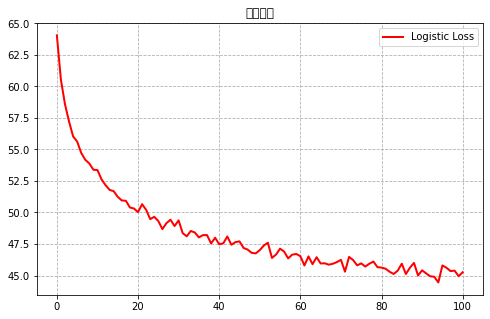

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:548: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test
test
test
total_test_accuracy: tensor(0.8542, device='cuda:0')
acc_test_each_k: tensor(0.8542, device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9208, device='cuda:0')
Training Epoch: 0, total loss: 45.643897
total_train_accuracy: tensor(0.9021, device='cuda:0')
Training Epoch: 1, total loss: 46.216918
total_train_accuracy: tensor(0.9229, device='cuda:0')
Training Epoch: 2, total loss: 45.268938
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 3, total loss: 45.182409
total_train_accuracy: tensor(0.9438, device='cuda:0')
Training Epoch: 4, total loss: 44.907625
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 5, total loss: 44.674940
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 6, total loss: 44.444976
total_train_accuracy: tensor(0.9396, device='cuda:0')
Training Epoch: 7, total loss: 45.004542
total_train_accuracy: tensor(0.9375, device='cuda:0')
Training Epoch: 8, total loss: 44.991088
total_train_

total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 85, total loss: 43.296207
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 86, total loss: 43.876127
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 87, total loss: 43.952988
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 88, total loss: 43.486501
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 89, total loss: 43.555663
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 90, total loss: 43.635295
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 91, total loss: 42.792780
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 92, total loss: 43.364857
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 93, total loss: 43.003577
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 94, total loss: 43.711964
total_train_accuracy: tensor(0.9625, dev

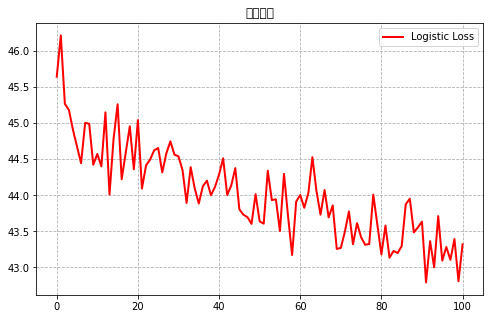

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 0, total loss: 43.593523
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 1, total loss: 43.565383
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 2, total loss: 43.942653
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 3, total loss: 43.905653
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 4, total loss: 43.337167
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 5, total loss: 42.843294
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 6, total loss: 43.246589
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 7, total loss: 43.107244
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 8, total loss: 43.082771
total_train_accuracy

total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 85, total loss: 42.535301
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 86, total loss: 42.900653
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 87, total loss: 42.868698
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 88, total loss: 43.395797
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 89, total loss: 42.547250
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 90, total loss: 43.086744
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 91, total loss: 42.883617
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 92, total loss: 43.023922
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 93, total loss: 43.160139
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 94, total loss: 42.832367
total_train_accuracy: tensor(0.9750, dev

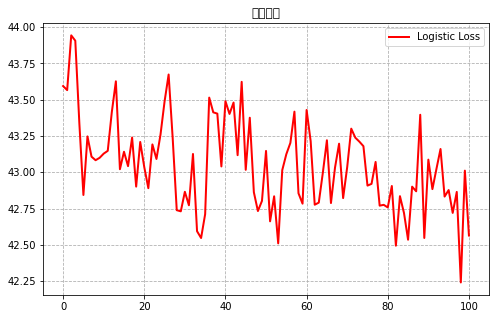

test
test
test
total_test_accuracy: tensor(0.9583, device='cuda:0')
acc_test_each_k: tensor(0.9583, device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 0, total loss: 43.092414
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 1, total loss: 42.962896
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 2, total loss: 42.960966
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 3, total loss: 43.036998
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 4, total loss: 43.241411
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 5, total loss: 42.767656
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 6, total loss: 43.183010
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 7, total loss: 43.282670
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 8, total loss: 42.867045
total_train_

total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 85, total loss: 42.703053
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 86, total loss: 42.404515
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 87, total loss: 42.934780
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 88, total loss: 42.447342
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 89, total loss: 42.513777
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 90, total loss: 42.333630
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 91, total loss: 42.756317
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 92, total loss: 42.565776
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 93, total loss: 42.458699
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 94, total loss: 42.628197
total_train_accuracy: tensor(0.9833, dev

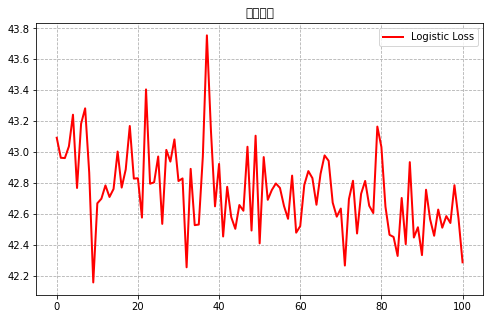

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 0, total loss: 42.679854
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 1, total loss: 43.105102
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 2, total loss: 42.287922
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 3, total loss: 42.579514
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 4, total loss: 42.915793
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 5, total loss: 42.562108
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 6, total loss: 42.783412
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 7, total loss: 42.863631
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 8, total loss: 43.295115
total_train_accuracy

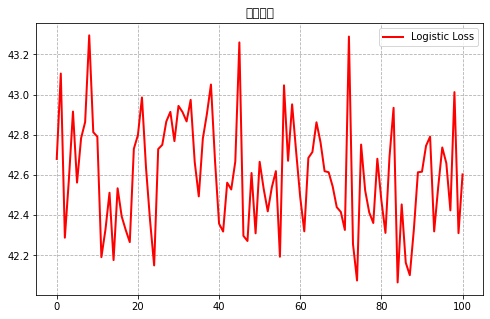

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 0, total loss: 42.794972
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 1, total loss: 42.971468
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 2, total loss: 43.046548
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 3, total loss: 42.537589
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 4, total loss: 42.529535
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 5, total loss: 42.614308
total_train_accuracy: tensor(0.9896, device='cuda:0')
Training Epoch: 6, total loss: 42.108172
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 7, total loss: 42.332475
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 8, total loss: 42.562141
total_train_accuracy

total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 85, total loss: 43.015240
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 86, total loss: 42.484351
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 87, total loss: 42.419440
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 88, total loss: 42.485935
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 89, total loss: 42.512056
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 90, total loss: 42.415049
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 91, total loss: 42.430992
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 92, total loss: 42.196212
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 93, total loss: 42.302259
total_train_accuracy: tensor(0.9521, device='cuda:0')
Training Epoch: 94, total loss: 43.036171
total_train_accuracy: tensor(0.9771, dev

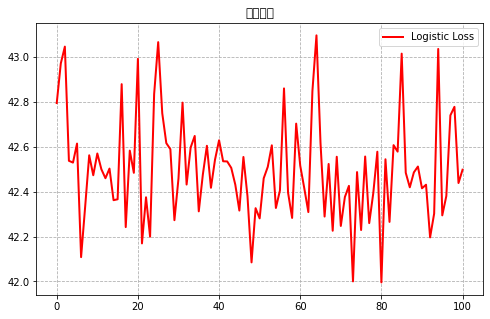

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 0, total loss: 42.645978
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 1, total loss: 42.504767
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 2, total loss: 42.182241
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 3, total loss: 42.207662
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 4, total loss: 42.034821
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 5, total loss: 42.606775
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 6, total loss: 42.385227
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 7, total loss: 41.998749
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 8, total loss: 42.430575
total_train_accuracy

total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 85, total loss: 42.607098
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 86, total loss: 42.047483
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 87, total loss: 42.322583
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 88, total loss: 42.073182
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 89, total loss: 42.558883
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 90, total loss: 41.970339
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 91, total loss: 42.218149
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 92, total loss: 42.494040
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 93, total loss: 42.364220
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 94, total loss: 42.153765
total_train_accuracy: tensor(0.9813, dev

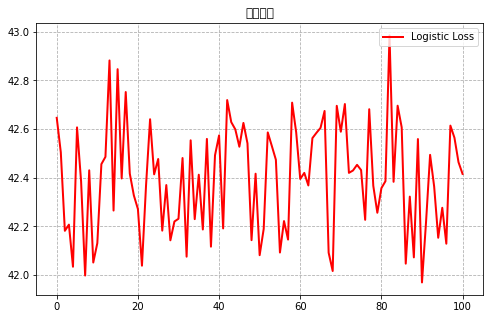

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 0, total loss: 42.260091
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 1, total loss: 42.584682
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 2, total loss: 42.324576
total_train_accuracy: tensor(0.9896, device='cuda:0')
Training Epoch: 3, total loss: 42.129282
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 4, total loss: 42.066781
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 5, total loss: 42.242978
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 6, total loss: 43.016972
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 7, total loss: 42.437035
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 8, total loss: 42.335884
total_train_accuracy

total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 85, total loss: 42.094835
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 86, total loss: 42.278141
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 87, total loss: 42.392311
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 88, total loss: 42.194080
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 89, total loss: 42.374256
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 90, total loss: 42.482488
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 91, total loss: 42.273576
total_train_accuracy: tensor(0.9771, device='cuda:0')
Training Epoch: 92, total loss: 42.317002
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 93, total loss: 42.376545
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 94, total loss: 42.105004
total_train_accuracy: tensor(0.9646, dev

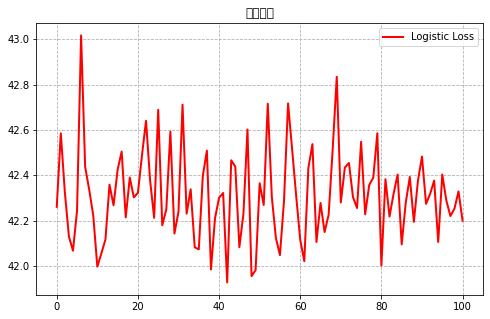

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 0, total loss: 42.726644
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 1, total loss: 42.973719
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 2, total loss: 41.881141
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 3, total loss: 42.536397
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 4, total loss: 41.961365
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 5, total loss: 42.295750
total_train_accuracy: tensor(0.9604, device='cuda:0')
Training Epoch: 6, total loss: 42.952308
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 7, total loss: 42.653499
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 8, total loss: 42.069083
total_train_accuracy

total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 85, total loss: 42.140731
total_train_accuracy: tensor(0.9896, device='cuda:0')
Training Epoch: 86, total loss: 41.871600
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 87, total loss: 41.791489
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 88, total loss: 42.332535
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 89, total loss: 42.306222
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 90, total loss: 42.448168
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 91, total loss: 42.345648
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 92, total loss: 42.108569
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 93, total loss: 42.173915
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 94, total loss: 42.225832
total_train_accuracy: tensor(0.9792, dev

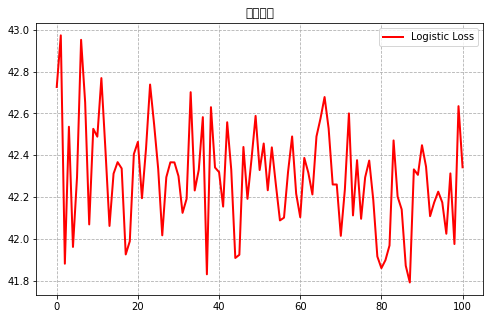

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 173
549 173
total_train_accuracy: tensor(0.9729, device='cuda:0')
Training Epoch: 0, total loss: 42.478942
total_train_accuracy: tensor(0.9646, device='cuda:0')
Training Epoch: 1, total loss: 42.422438
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 2, total loss: 42.001454
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 3, total loss: 41.987238
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 4, total loss: 42.568584
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 5, total loss: 42.129089
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 6, total loss: 42.182410
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 7, total loss: 42.205319
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 8, total loss: 42.509197
total_train_accuracy

total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 85, total loss: 41.791521
total_train_accuracy: tensor(0.9688, device='cuda:0')
Training Epoch: 86, total loss: 42.547188
total_train_accuracy: tensor(0.9563, device='cuda:0')
Training Epoch: 87, total loss: 42.701361
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 88, total loss: 42.126757
total_train_accuracy: tensor(0.9854, device='cuda:0')
Training Epoch: 89, total loss: 42.102312
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 90, total loss: 42.476935
total_train_accuracy: tensor(0.9813, device='cuda:0')
Training Epoch: 91, total loss: 42.162492
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 92, total loss: 42.493910
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 93, total loss: 42.023269
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 94, total loss: 41.946552
total_train_accuracy: tensor(0.9875, dev

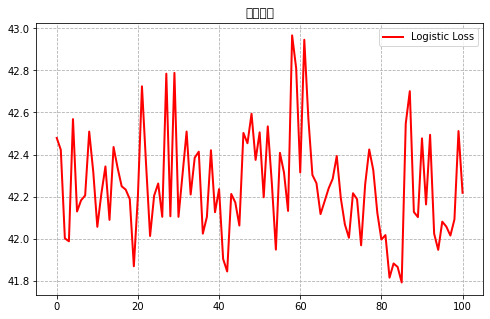

test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
[tensor(0.8542, device='cuda:0'), tensor(1., device='cuda:0'), tensor(0.9583, device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
[array(0.8541667, dtype=float32), array(1., dtype=float32), array(0.9583334, dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32)]
acc_test_metrics: 0.98125


In [5]:
model=model5
K=10
test_metrics=[]
train_loss_total_list=[]
for ki in range(K):
    trainset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/30_train_val_info.csv',K=K, n_class=nfm_config['n_class'],ki=ki,  typ='train', transform=None, rand=True)
    valset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/30_train_val_info.csv', K=K,n_class=nfm_config['n_class'],ki=ki,  typ='val', transform=None, rand=True)
    train_loader = data.DataLoader(
         dataset=trainset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size'],
         shuffle=True)
    val_loader = data.DataLoader(
         dataset=valset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size']
        
     )
    
    model_path='models/ConvAttMLP/30'
    #BATCH_SIZE=batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=nfm_config['lr'], weight_decay=nfm_config['l2_regularization'])
    #total = 0
    
    
    loss_func=torch.nn.CrossEntropyLoss()
    
    num=0
   
    
    epoches=101
    for epoch_id in range(epoches):
          
        
        
        train_loss_total,acc_train=train_epoch(model,train_loader,nfm_config['batch_size'],optimizer,loss_func)
        train_loss_total_list.append(train_loss_total)#
        if epoch_id %20==0:
            num=num+1
            #path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pkl')
            #torch.save(model.state_dict(),path)
            # 保存模型
            
            path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pt')##################pt
            torch.save(model.state_dict(),path)
            #torch.save(model.state_dict(),path)
    print("the ",ki," epoch ends")
    plotLoss(train_loss_total_list,epoches)
    train_loss_total_list=[]
    acc_test=val_epoch(model,val_loader,nfm_config['batch_size'],optimizer)
    print("acc_test_each_k:",acc_test)
    test_metrics.append(acc_test)

print(test_metrics)
#test_metrics=test_metrics.tolist()
test_metrics=[x.cpu().detach().numpy() for x in test_metrics]
print(test_metrics)
acc_test_metrics=np.mean(test_metrics) 
print("acc_test_metrics:",acc_test_metrics)
       


MLP5(
  (bn0): BatchNorm1d(172, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=172, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)
138 173
f1_score:  %.4f 0.8898728873083878
accuracy_score: 0.8913043478260869
recall_score: 0.8846524934760228
pre_recall: 0.9144423360742147
n_classes: 9


/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

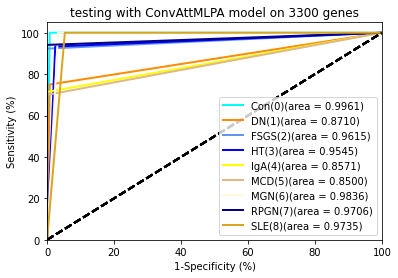

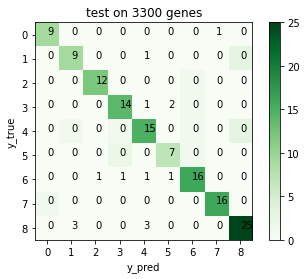

In [6]:
import torch

#功能：加载保存到path中的各层参数到神经网络

#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP610.pkl'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP9110.pkl'
path='models/ConvAttMLP/30/MLP610.pt'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP10910.pkl'
#nfm=NFM(nfm_config)
#mlp=MLP()
mlp=MLP5()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP/30_test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    #plt.title('testing on kidney tubules with F800 without augment') 
    plt.title('testing with ConvAttMLPA model on 3300 genes')   

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 

#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('test on 3300 genes')      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show()